In [2]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns
import matplotlib.gridspec as gridspec
from pylab import *
import pdb
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import linregress
import matplotlib.patheffects as path_effects

In [3]:
ds_sst = xr.open_dataset('sst_all_conv.nc')

In [4]:
sst1 = []
for i in np.arange(0,len(ds_sst.sst)):
    sst1.append(ds_sst.sst[i] - ds_sst.sst[i].mean())
sst = xr.concat(sst1,dim='time')
sst = np.array(sst[10*4:30*4]).flatten()

In [5]:
def sort_it(ini,end,anom):
    ds_sst = xr.open_dataset('sst_all_conv.nc')
    ds_tcwv = xr.open_dataset('tcwv_all_conv.nc')
    sort = np.argsort(np.array(ds_tcwv.tcwv[ini*4:end*4]).flatten()) 
    if anom == True:
        sst1 = []
        for i in np.arange(0,len(ds_sst.sst)):
            sst1.append(ds_sst.sst[i] - ds_sst.sst[i].mean())
        sst = xr.concat(sst1,dim='time')
        sst = np.array(sst[ini*4:end*4]).flatten()
        tcw = np.array(ds_tcwv.tcwv[ini*4:end*4]).flatten() 
    else:
        sst = np.array(ds_sst.sst[ini*4:end*4]).flatten() 
        tcw = np.array(ds_tcwv.tcwv[ini*4:end*4]).flatten()
    return(sst,tcw)

def scatter_box(sst,tcwv,tipo,nbin):
    df1 = pd.DataFrame(data = {'tcwv': tcwv})
    df1['bins'] = pd.cut(df1['tcwv'], nbin, precision = 4)
    df = pd.DataFrame(data = {'sst_'+tipo: sst})
    df = df.melt(value_vars=['sst_'+tipo],
                 var_name='Conditions', value_name='Value', ignore_index=False)
    df['bins'] = df1['bins']
    
    # Calculate the mean of sst for each bin
    mean_values = df.groupby('bins')['Value'].mean().reset_index()

    # Extract the bin centers (mean of the bin edges)
    mean_values['bin_centers'] = mean_values['bins'].apply(lambda x: x.mid)

    # Drop NaN values from mean_values
    mean_values.dropna(inplace=True)

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(mean_values['bin_centers'], mean_values['Value'])
    return(df, mean_values, (slope, intercept, r_value, p_value, std_err))


In [6]:
rev_sst,rev_tcwv = sort_it(10,30,True)
org_sst,org_tcwv = sort_it(60,80,True)
bins = np.arange(5,71,5)
df_rev, mod_rev_mean, mod_reg_rev = scatter_box(rev_sst,rev_tcwv,'rev',bins)
df_rev = df_rev[df_rev['bins'] != pd.Interval(65, 70)]
#df_rev = df_rev[df_rev['bins'] != pd.Interval(0, 5)]

df_org, mod_org_mean, mod_reg_org = scatter_box(org_sst,org_tcwv,'org',bins)
#df_org = df_org[df_org['bins'] != pd.Interval(0, 5)]
df_org = df_org[df_org['bins'] != pd.Interval(65, 70)]

df_tot = pd.concat([df_rev,df_org])

/var/folders/30/gtfddbxx5z3f_hc8v4br4pkh0000gn/T/ipykernel_68499/2283877931.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_values = df.groupby('bins')['Value'].mean().reset_index()
/var/folders/30/gtfddbxx5z3f_hc8v4br4pkh0000gn/T/ipykernel_68499/2283877931.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_values = df.groupby('bins')['Value'].mean().reset_index()


/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


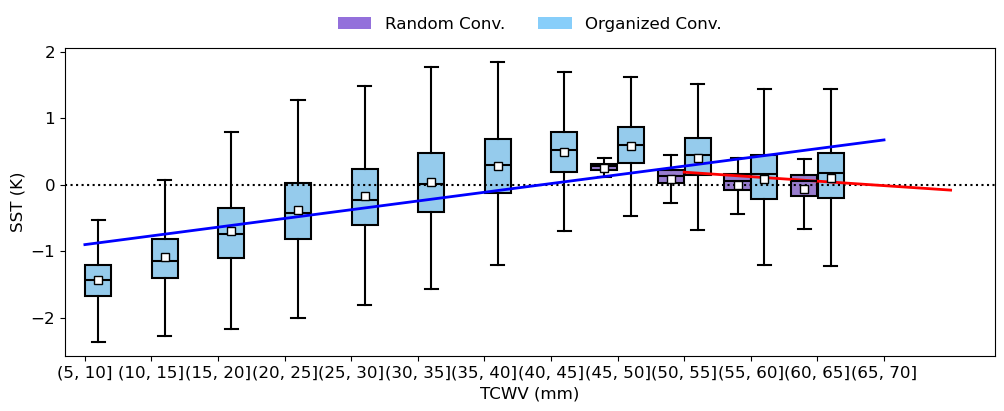

In [7]:
plt.figure(figsize=(12,4))
bp = sns.boxplot(data = df_tot, x='bins', y='Value', hue='Conditions', 
                 palette=['mediumpurple','lightskyblue'],showmeans=True,
                 flierprops = dict(marker='.', markersize=3, color = 'k', markeredgecolor = 'k'),
                 meanprops = {"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"},
                 boxprops = dict(edgecolor='black'),
                 medianprops = dict(color = 'black'),
                 whiskerprops = dict(color = 'black'),
                 capprops = dict(color = 'black'), showfliers= False)
plt.axhline(0, color = 'k', linestyle=':')
plt.plot(np.arange(9,14), (mod_reg_rev[1] + mod_reg_rev[0] * np.array(mod_rev_mean['bin_centers'])), 
         color = 'red', linewidth = 2)
plt.plot((mod_reg_org[1] + mod_reg_org[0] * np.array(mod_org_mean['bin_centers'])), 
         color = 'blue', linewidth = 2)
#plt.axhline(rev_sst.mean(), color = 'k', linestyle=':')
random = mpatches.Rectangle((0, 0), 1, 1, facecolor="mediumpurple")
organized = mpatches.Rectangle((0, 0), 1, 1, facecolor="lightskyblue")
plt.legend([random,organized], ['Random Conv.','Organized Conv.'], loc = 'upper center', ncol=2,
           bbox_to_anchor = (0.5,1.15), frameon = False, fontsize = 12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('SST (K)', fontsize = 12)
plt.xlabel('TCWV (mm)', fontsize = 12)
plt.savefig('sst_function_tcwv_ideal.jpg', bbox_inches='tight',dpi=300)
plt.savefig('sst_function_tcwv_ideal.pdf', bbox_inches='tight',dpi=300)

plt.show()

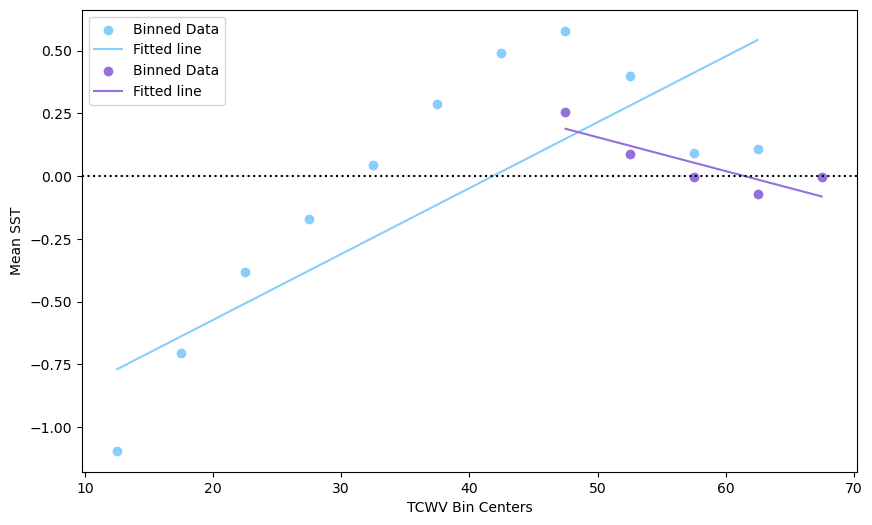

In [8]:
# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(mod_org_mean['bin_centers'][1:-1], mod_org_mean['Value'][1:-1], label='Binned Data', color = 'lightskyblue')
plt.plot(np.array(mod_org_mean['bin_centers'][1:-1]), mod_reg_org[1] + mod_reg_org[0] * np.array(mod_org_mean['bin_centers'][1:-1]),
         color = 'lightskyblue', label='Fitted line')

plt.scatter(mod_rev_mean['bin_centers'], mod_rev_mean['Value'], label='Binned Data', color = 'mediumpurple')
plt.plot(np.array(mod_rev_mean['bin_centers']), mod_reg_rev[1] + mod_reg_rev[0] * np.array(mod_rev_mean['bin_centers']),
         color = 'mediumpurple', label='Fitted line')

plt.axhline(0, color = 'k', linestyle = ':')

plt.xlabel('TCWV Bin Centers')
plt.ylabel('Mean SST')
#plt.title(f'Linear Regression of Binned SST vs. TCWV')
plt.legend()
plt.show()

## Observations Variance

In [9]:
def sort_it_obs(ds_sst,ds_tcwv,ini,end,anom):
    if anom == True:
        sst1 = []
        #pdb.set_trace()
        for i in np.arange(0,len(ds_sst.sst)):
            sst1.append(ds_sst.sst[i] - ds_sst.sst[i].mean())
        sst = xr.concat(sst1,dim='time')
        sst = sst[ini:end]
        tcw = ds_tcwv.tcwv[ini:end]
    else:
        sst = ds_sst.sst[ini:end] 
        tcw = ds_tcwv.tcwv[ini:end]
    return(sst,tcw)

In [10]:
path = '/Users/acasalla/Documents/PhD/Thesis/NN_real/Area_2-9_135-145_ERA5/'

pw_obs = xr.open_dataset(path+'Mimic_area_ERA5_grid.nc')
df_pwm = xr.open_dataset(path+'Mimic_area_fldmean.nc')
df_pws = xr.open_dataset(path+'Mimic_area_fldstd.nc')
df_pwi = pd.read_csv(path+'TPW_IQR_area_2-9_135-145.csv', parse_dates=True, index_col=0)

In [11]:
path = '/Users/acasalla/Documents/PhD/Thesis/NN_real/Area_2-9_135-145_ERA5/'
ds_sst = xr.open_dataset(path+'SST_std.nc')
ds_tcwv = xr.open_dataset(path+'TCWV_std.nc')
df_slope = pd.read_csv(path+'Slopes_data_2-9_135-145_ERA5.csv', parse_dates = True, index_col = 0)
tcwv_obs = xr.open_dataset(path+'TCWV_area.nc')
pw_obs = xr.open_dataset(path+'Mimic_area_ERA5_grid.nc')

sst = ds_sst.sst[:,0,0]
tcw = ds_tcwv.tcwv[:,0,0]
#df_slope['State'] = np.where(df_slope['Slope'] < df_slope['Slope'].mean()+0.5*df_slope['Slope'].std(),
#                             'Reversal', 'Organized')

df_ss = xr.open_dataset(path+'SST_fldmean.nc')
df_wv = xr.open_dataset(path+'TCWV_fldmean.nc')

df_slope['SST_mean'] = df_ss.sst[:,0,0].values[0:35040]
df_slope['TCWV_mean'] = df_wv.tcwv[:,0,0].values[0:35040]
df_slope['SST_std'] = ds_sst.sst[:,0,0].values[0:35040]
df_slope['TCWV_std'] = ds_tcwv.tcwv[:,0,0].values[0:35040]
df_slope['TCWV_min'] = tcwv_obs.tcwv.min(dim=['latitude','longitude']).values[0:35040]
df_slope['TCWV_p5'] = tcwv_obs.tcwv.quantile(0.05,dim=['latitude','longitude']).values[0:35040]


In [12]:
try:
    sst_obs = xr.open_dataset('SST_anom_per_time.nc')
    tcwv_obs = xr.open_dataset(path+'TCWV_area.nc')
except:
    ds_sst = xr.open_dataset(path+'SST_area.nc')
    ds_tcwv = xr.open_dataset(path+'TCWV_area.nc')
    sst_obs, tcwv_obs = sort_it_obs(ds_sst,ds_tcwv,0,35040,True)
    sst_obs.to_netcdf('SST_anom_per_time.nc')

In [13]:
df_djf = df_slope[df_slope.index.month.isin([12,1,2])]
df_mam = df_slope[df_slope.index.month.isin([3,4,5])]
df_jja = df_slope[df_slope.index.month.isin([6,7,8])]
df_son = df_slope[df_slope.index.month.isin([9,10,11])]
df_wint = df_slope[df_slope.index.month.isin([12,1,2,3,4,5])]
df_wint = df_wint.resample('D').mean()
df_summ = df_slope[df_slope.index.month.isin([6,7,8,9,10,11])]
df_summ = df_summ.resample('D').mean()

## Daily
pwv_data = df_slope.loc['2017-01-01 00:00:00':'2019-12-30']
pwv_data['PWV_mean'] = df_pwm.tpwGrid.values[0:26256,0,0]
pwv_data['PWV_std'] = df_pws.tpwGrid.values[0:26256,0,0]
pwv_data['PWV_min'] = pw_obs.tpwGrid.min(dim=['latitude','longitude']).values[0:26256]
pwv_data['PWV_p5'] = pw_obs.tpwGrid.quantile(0.05,dim=['latitude','longitude']).values[0:26256]
pwv_data['PWV_p5_2'] = np.nanpercentile(np.array(pw_obs.tpwGrid.values[0:26256]),5, axis = (1,2))

pw_wint = pwv_data[pwv_data.index.month.isin([12,1,2,3,4,5])]
pw_summ = pwv_data[pwv_data.index.month.isin([6,7,8,9,10,11])]
pw_djf = pwv_data[pwv_data.index.month.isin([12,1,2])]
pw_mam = pwv_data[pwv_data.index.month.isin([3,4,5])]
pw_jja = pwv_data[pwv_data.index.month.isin([6,7,8])]
pw_son = pwv_data[pwv_data.index.month.isin([9,10,11])]

/var/folders/30/gtfddbxx5z3f_hc8v4br4pkh0000gn/T/ipykernel_68499/4118455682.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pwv_data['PWV_mean'] = df_pwm.tpwGrid.values[0:26256,0,0]
/var/folders/30/gtfddbxx5z3f_hc8v4br4pkh0000gn/T/ipykernel_68499/4118455682.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pwv_data['PWV_std'] = df_pws.tpwGrid.values[0:26256,0,0]
/var/folders/30/gtfddbxx5z3f_hc8v4br4pkh0000gn/T/ipykernel_68499/4118455682.py:14: SettingWithCopyWarning: 
A value is trying to be set on 

In [14]:
test = pwv_data.loc['20170101':'20170630']
te_wint = test[test.index.month.isin([12,1,2,3,4,5])]
#te_wint = te_wint.resample('D').mean()
te_summ = test[test.index.month.isin([6,7,8,9,10,11])]
#te_summ = te_summ.resample('D').mean()

### Hex plot for joint pdf

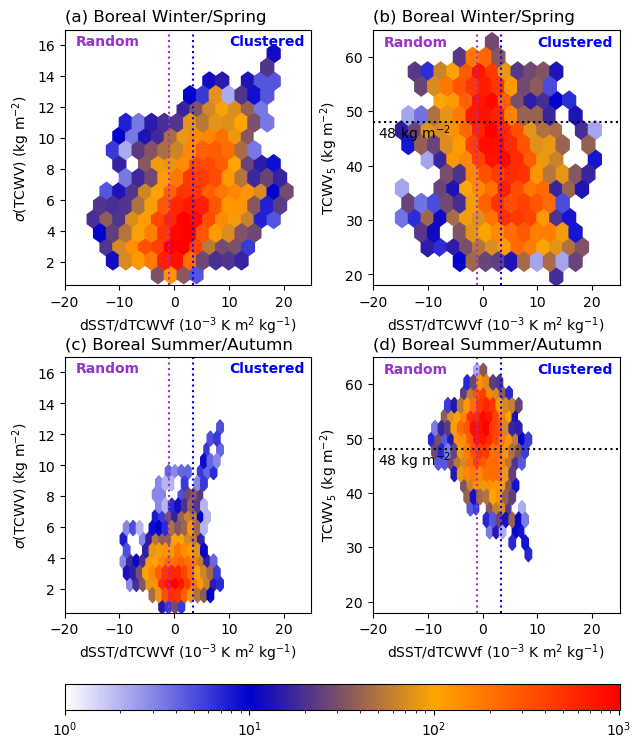

In [15]:
cmap=LinearSegmentedColormap.from_list('', ['white', 'mediumblue','orange','red'])
bintype="log"
gridsize = 15

plt.figure(figsize=(6,8.5))
gs = gridspec.GridSpec(3,2, left=0.05, right=0.975, hspace=0.4, wspace=0.25, top=0.9, bottom=0.1,
                      height_ratios=[1,1,0.1])

ax=subplot(gs[0])
cax0=ax.hexbin(pw_wint['Slope']*1000,pw_wint['TCWV_std'],gridsize=gridsize,bins=bintype,cmap=cmap,label="frfr")
ax.set_xlabel("dSST/dTCWVf (10$^{-3}$ K m$^{2}$ kg$^{-1}$)")
ax.set_ylabel("$\sigma$(TCWV) (kg m$^{-2}$)")
plt.title('(a) Boreal Winter/Spring', loc ='left')
plt.xlim(-20,25)
plt.ylim(0.5,17)
ax.axvline((df_slope.Slope.mean()+df_slope.Slope.std()*0.5)*1000,color="blue",linestyle="dotted")
ax.axvline((df_slope.Slope.mean()-df_slope.Slope.std()*0.5)*1000,color="darkorchid",linestyle="dotted")
ax.text(-18,16,"Random", fontweight = 'bold', color = 'darkorchid')
ax.text(10,16,"Clustered", fontweight = 'bold', color = 'blue')

ax=subplot(gs[1])
cax1=ax.hexbin(pw_wint['Slope']*1000,pw_wint['TCWV_p5'],gridsize=gridsize,bins=bintype,cmap=cmap,label="frfr")
ax.set_xlabel("dSST/dTCWVf (10$^{-3}$ K m$^{2}$ kg$^{-1}$)")
ax.set_ylabel("TCWV$_{5}$ (kg m$^{-2}$)")
plt.title('(b) Boreal Winter/Spring', loc ='left')
plt.xlim(-20,25)
plt.ylim(18,65)
ax.axvline((df_slope.Slope.mean()+df_slope.Slope.std()*0.5)*1000,color="blue",linestyle="dotted")
ax.axvline((df_slope.Slope.mean()-df_slope.Slope.std()*0.5)*1000,color="darkorchid",linestyle="dotted")
ax.axhline(48,color ='k', linestyle=':')
ax.text(-18,62,"Random", fontweight = 'bold', color = 'darkorchid')
ax.text(10,62,"Clustered", fontweight = 'bold', color = 'blue')
ax.text(-19,45,"48 kg m$^{-2}$")

ax=subplot(gs[2])
cax0=ax.hexbin(pw_summ['Slope']*1000,pw_summ['TCWV_std'],gridsize=gridsize,bins=bintype,cmap=cmap,label="frfr")
ax.set_xlabel("dSST/dTCWVf (10$^{-3}$ K m$^{2}$ kg$^{-1}$)")
ax.set_ylabel("$\sigma$(TCWV) (kg m$^{-2}$)")
plt.title('(c) Boreal Summer/Autumn', loc ='left')
plt.xlim(-20,25)
plt.ylim(0.5,17)
ax.axvline((df_slope.Slope.mean()+df_slope.Slope.std()*0.5)*1000,color="blue",linestyle="dotted")
ax.axvline((df_slope.Slope.mean()-df_slope.Slope.std()*0.5)*1000,color="darkorchid",linestyle="dotted")
ax.text(-18,16,"Random", fontweight = 'bold', color = 'darkorchid')
ax.text(10,16,"Clustered", fontweight = 'bold', color = 'blue')

ax=subplot(gs[3])
cax1=ax.hexbin(pw_summ['Slope']*1000,pw_summ['TCWV_p5'],gridsize=gridsize,bins=bintype,cmap=cmap,label="frfr")
ax.set_xlabel("dSST/dTCWVf (10$^{-3}$ K m$^{2}$ kg$^{-1}$)")
ax.set_ylabel("TCWV$_{5}$ (kg m$^{-2}$)")
plt.title('(d) Boreal Summer/Autumn', loc ='left')
plt.xlim(-20,25)
plt.ylim(18,65)
ax.axvline((df_slope.Slope.mean()+df_slope.Slope.std()*0.5)*1000,color="blue",linestyle="dotted")
ax.axvline((df_slope.Slope.mean()-df_slope.Slope.std()*0.5)*1000,color="darkorchid",linestyle="dotted")
ax.axhline(48,color ='k', linestyle=':')
ax.text(-18,62,"Random", fontweight = 'bold', color = 'darkorchid')
ax.text(10,62,"Clustered", fontweight = 'bold', color = 'blue')
ax.text(-19,45,"48 kg m$^{-2}$")

cax=subplot(gs[2,:])
bar = plt.colorbar(cax0,cax=cax,orientation="horizontal")

plt.savefig('joint_pdf_SST_TCWV_wint_summ.jpg', bbox_inches='tight',dpi=300)
plt.savefig('joint_pdf_SST_TCWV_wint_summ.pdf', bbox_inches='tight',dpi=300)

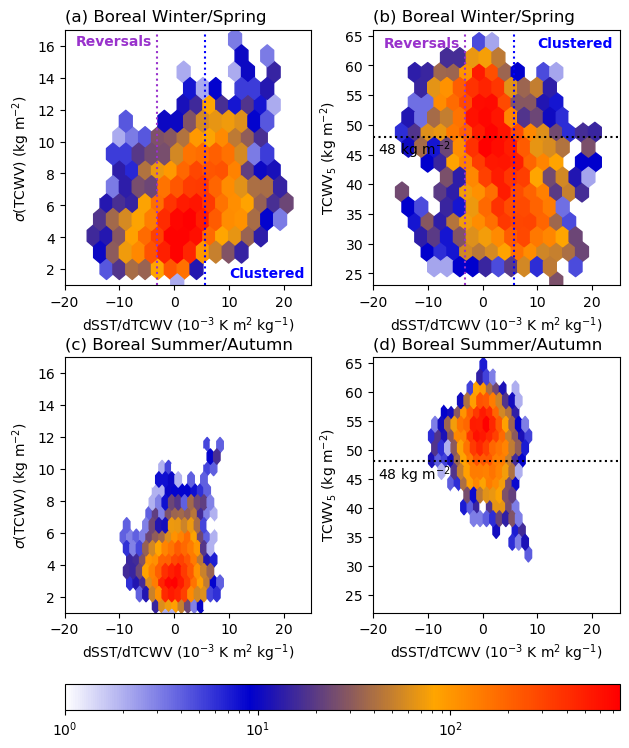

In [36]:
bintype="log"
gridsize = 15

plt.figure(figsize=(6,8.5))
gs = gridspec.GridSpec(3,2, left=0.05, right=0.975, hspace=0.4, wspace=0.25, top=0.9, bottom=0.1,
                      height_ratios=[1,1,0.1])

ax=subplot(gs[0])
cax0=ax.hexbin(pw_wint['Slope']*1000,pw_wint['PWV_std'],gridsize=gridsize,bins=bintype,cmap=cmap,label="frfr")
ax.set_xlabel("dSST/dTCWV (10$^{-3}$ K m$^{2}$ kg$^{-1}$)")
ax.set_ylabel("$\sigma$(TCWV) (kg m$^{-2}$)")
plt.title('(a) Boreal Winter/Spring', loc ='left')
plt.xlim(-20,25)
plt.ylim(1,17)
ax.axvline((df_slope.Slope.mean()+df_slope.Slope.std())*1000,color="blue",linestyle="dotted")
ax.axvline((df_slope.Slope.mean()-df_slope.Slope.std())*1000,color="darkorchid",linestyle="dotted")
ax.text(-18,16,"Reversals", fontweight = 'bold', color = 'darkorchid')
ax.text(10,1.5,"Clustered", fontweight = 'bold', color = 'blue')

ax=subplot(gs[1])
cax1=ax.hexbin(pw_wint['Slope']*1000,pw_wint['PWV_p5'],gridsize=gridsize,bins=bintype,cmap=cmap,label="frfr")
ax.set_xlabel("dSST/dTCWV (10$^{-3}$ K m$^{2}$ kg$^{-1}$)")
ax.set_ylabel("TCWV$_{5}$ (kg m$^{-2}$)")
plt.title('(b) Boreal Winter/Spring', loc ='left')
plt.xlim(-20,25)
plt.ylim(23,66)
ax.axvline((df_slope.Slope.mean()+df_slope.Slope.std())*1000,color="blue",linestyle="dotted")
ax.axvline((df_slope.Slope.mean()-df_slope.Slope.std())*1000,color="darkorchid",linestyle="dotted")
ax.axhline(48,color ='k', linestyle=':')
ax.text(-18,63,"Reversals", fontweight = 'bold', color = 'darkorchid')
ax.text(10,63,"Clustered", fontweight = 'bold', color = 'blue')
ax.text(-19,45,"48 kg m$^{-2}$")

ax=subplot(gs[2])
cax0=ax.hexbin(pw_summ['Slope']*1000,pw_summ['PWV_std'],gridsize=gridsize,bins=bintype,cmap=cmap,label="frfr")
ax.set_xlabel("dSST/dTCWV (10$^{-3}$ K m$^{2}$ kg$^{-1}$)")
ax.set_ylabel("$\sigma$(TCWV) (kg m$^{-2}$)")
plt.title('(c) Boreal Summer/Autumn', loc ='left')
plt.xlim(-20,25)
plt.ylim(1,17)
#ax.axvline((df_slope.Slope.mean()+df_slope.Slope.std())*1000,color="blue",linestyle="dotted")
#ax.axvline((df_slope.Slope.mean()-df_slope.Slope.std())*1000,color="darkorchid",linestyle="dotted")
#ax.text(-18,16,"Reversals", fontweight = 'bold', color = 'darkorchid')
#ax.text(10,16,"Clustered", fontweight = 'bold', color = 'blue')

ax=subplot(gs[3])
cax1=ax.hexbin(pw_summ['Slope']*1000,pw_summ['PWV_p5'],gridsize=gridsize,bins=bintype,cmap=cmap,label="frfr")
ax.set_xlabel("dSST/dTCWV (10$^{-3}$ K m$^{2}$ kg$^{-1}$)")
ax.set_ylabel("TCWV$_{5}$ (kg m$^{-2}$)")
plt.title('(d) Boreal Summer/Autumn', loc ='left')
plt.xlim(-20,25)
plt.ylim(22,66)
#ax.axvline((df_slope.Slope.mean()+df_slope.Slope.std())*1000,color="blue",linestyle="dotted")
#ax.axvline((df_slope.Slope.mean()-df_slope.Slope.std())*1000,color="darkorchid",linestyle="dotted")
ax.axhline(48,color ='k', linestyle=':')
#ax.text(-18,63,"Reversals", fontweight = 'bold', color = 'darkorchid')
#ax.text(10,63,"Clustered", fontweight = 'bold', color = 'blue')
ax.text(-19,45,"48 kg m$^{-2}$")

cax=subplot(gs[2,:])
bar = plt.colorbar(cax0,cax=cax,orientation="horizontal")
plt.savefig('joint_pdf_SST_PWV_wint_summ1.jpg', bbox_inches='tight',dpi=300)
plt.savefig('joint_pdf_SST_PWV_wint_summ1.pdf', bbox_inches='tight',dpi=300)

In [17]:
(df_slope.Slope.mean()+df_slope.Slope.std()*0.5)*1000

3.448083979422086

In [18]:
(df_slope.Slope.mean()-df_slope.Slope.std()*0.5)*1000

-0.9524432862262084

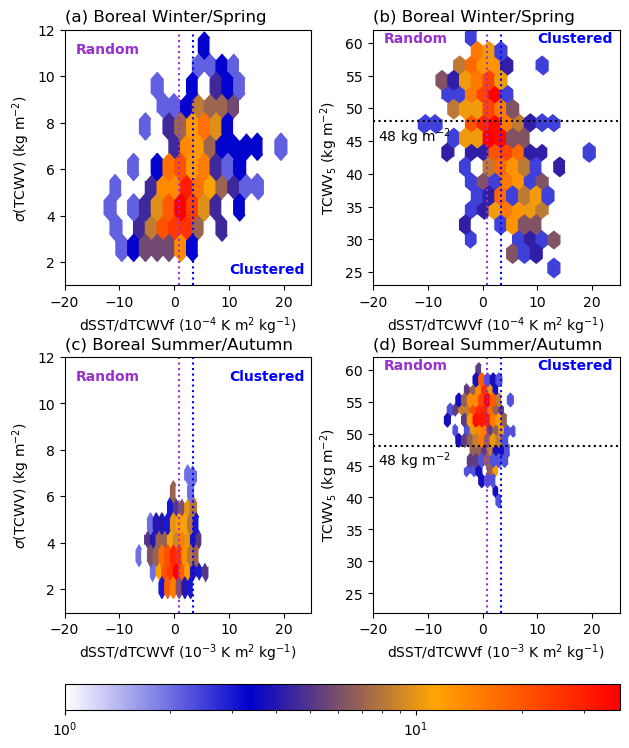

In [19]:
bintype='log'
gridsize = 15

plt.figure(figsize=(6,8.5))
gs = gridspec.GridSpec(3,2, left=0.05, right=0.975, hspace=0.4, wspace=0.25, top=0.9, bottom=0.1,
                      height_ratios=[1,1,0.1])

ax=subplot(gs[0])
cax0=ax.hexbin(pw_wint['Slope'].resample('D').mean()*1000,pw_wint['PWV_std'].resample('D').mean(),
               gridsize=gridsize,bins=bintype,cmap=cmap,label="frfr")
ax.set_xlabel("dSST/dTCWVf (10$^{-4}$ K m$^{2}$ kg$^{-1}$)")
ax.set_ylabel("$\sigma$(TCWV) (kg m$^{-2}$)")
plt.title('(a) Boreal Winter/Spring', loc ='left')
plt.xlim(-20,25)
plt.ylim(1,12)
ax.axvline((df_slope.Slope.resample('D').mean().std()*0.5+df_slope.Slope.resample('D').mean().mean())*1000,
           color="blue",linestyle="dotted")
ax.axvline((df_slope.Slope.resample('D').mean().std()*0.5-df_slope.Slope.resample('D').mean().mean())*1000,
           color="darkorchid",linestyle="dotted")
ax.text(-18,11,"Random", fontweight = 'bold', color = 'darkorchid')
ax.text(10,1.5,"Clustered", fontweight = 'bold', color = 'blue')

ax=subplot(gs[1])
cax1=ax.hexbin(pw_wint['Slope'].resample('D').mean()*1000,pw_wint['PWV_p5'].resample('D').mean(),
               gridsize=gridsize,bins=bintype,cmap=cmap,label="frfr")
ax.set_xlabel("dSST/dTCWVf (10$^{-4}$ K m$^{2}$ kg$^{-1}$)")
ax.set_ylabel("TCWV$_{5}$ (kg m$^{-2}$)")
plt.title('(b) Boreal Winter/Spring', loc ='left')
plt.xlim(-20,25)
plt.ylim(23,62)
ax.axvline((df_slope.Slope.resample('D').mean().std()*0.5+df_slope.Slope.resample('D').mean().mean())*1000,
           color="blue",linestyle="dotted")
ax.axvline((df_slope.Slope.resample('D').mean().std()*0.5-df_slope.Slope.resample('D').mean().mean())*1000,
           color="darkorchid",linestyle="dotted")
ax.axhline(48,color ='k', linestyle=':')
ax.text(-18,60,"Random", fontweight = 'bold', color = 'darkorchid')
ax.text(10,60,"Clustered", fontweight = 'bold', color = 'blue')
ax.text(-19,45,"48 kg m$^{-2}$")

ax=subplot(gs[2])
cax0=ax.hexbin(pw_summ['Slope'].resample('D').mean()*1000,pw_summ['PWV_std'].resample('D').mean(),
               gridsize=gridsize,bins=bintype,cmap=cmap,label="frfr")
ax.set_xlabel("dSST/dTCWVf (10$^{-3}$ K m$^{2}$ kg$^{-1}$)")
ax.set_ylabel("$\sigma$(TCWV) (kg m$^{-2}$)")
plt.title('(c) Boreal Summer/Autumn', loc ='left')
plt.xlim(-20,25)
plt.ylim(1,12)
ax.axvline((df_slope.Slope.resample('D').mean().std()*0.5+df_slope.Slope.resample('D').mean().mean())*1000,
           color="blue",linestyle="dotted")
ax.axvline((df_slope.Slope.resample('D').mean().std()*0.5-df_slope.Slope.resample('D').mean().mean())*1000,
           color="darkorchid",linestyle="dotted")
ax.text(-18,11,"Random", fontweight = 'bold', color = 'darkorchid')
ax.text(10,11,"Clustered", fontweight = 'bold', color = 'blue')

ax=subplot(gs[3])
cax1=ax.hexbin(pw_summ['Slope'].resample('D').mean()*1000,pw_summ['PWV_p5'].resample('D').mean(),
               gridsize=gridsize,bins=bintype,cmap=cmap,label="frfr")
ax.set_xlabel("dSST/dTCWVf (10$^{-3}$ K m$^{2}$ kg$^{-1}$)")
ax.set_ylabel("TCWV$_{5}$ (kg m$^{-2}$)")
plt.title('(d) Boreal Summer/Autumn', loc ='left')
plt.xlim(-20,25)
plt.ylim(22,62)
ax.axvline((df_slope.Slope.resample('D').mean().std()*0.5+df_slope.Slope.resample('D').mean().mean())*1000,
           color="blue",linestyle="dotted")
ax.axvline((df_slope.Slope.resample('D').mean().std()*0.5-df_slope.Slope.resample('D').mean().mean())*1000,
           color="darkorchid",linestyle="dotted")
ax.axhline(48,color ='k', linestyle=':')
ax.text(-18,60,"Random", fontweight = 'bold', color = 'darkorchid')
ax.text(10,60,"Clustered", fontweight = 'bold', color = 'blue')
ax.text(-19,45,"48 kg m$^{-2}$")

cax=subplot(gs[2,:])
bar = plt.colorbar(cax0,cax=cax,orientation="horizontal")

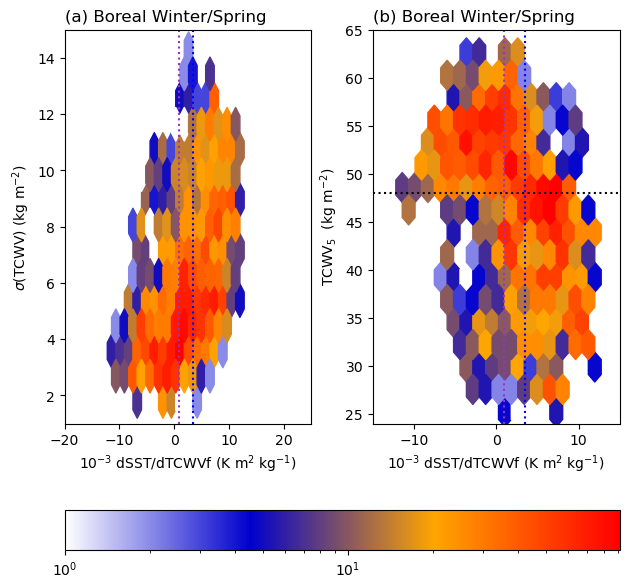

In [20]:
gridsize = 15
plt.figure(figsize=(6,6.5))
gs = gridspec.GridSpec(2,2, left=0.05, right=0.975, hspace=0.4, wspace=0.25, top=0.9, bottom=0.1,
                      height_ratios=[1,0.1])

ax=subplot(gs[0])
cax0=ax.hexbin(te_wint['Slope']*1000,te_wint['PWV_std'],gridsize=gridsize,bins=bintype,cmap=cmap,label="frfr")
ax.set_xlabel("10$^{-3}$ dSST/dTCWVf (K m$^{2}$ kg$^{-1}$)")
ax.set_ylabel("$\sigma$(TCWV) (kg m$^{-2}$)")
plt.title('(a) Boreal Winter/Spring', loc ='left')
plt.xlim(-20,25)
plt.ylim(1,15)
ax.axvline((df_slope.Slope.std()*0.5+df_slope.Slope.mean())*1000,color="blue",linestyle="dotted")
ax.axvline((df_slope.Slope.std()*0.5-df_slope.Slope.mean())*1000,color="darkorchid",linestyle="dotted")
#ax.text(-18,28,"Random", fontweight = 'bold', color = 'darkorchid')
#ax.text(10,0.5,"Clustered", fontweight = 'bold', color = 'blue')

ax=subplot(gs[1])
cax1=ax.hexbin(te_wint['Slope']*1000,te_wint['PWV_p5_2'],gridsize=gridsize,bins=bintype,cmap=cmap,label="frfr")
ax.set_xlabel("10$^{-3}$ dSST/dTCWVf (K m$^{2}$ kg$^{-1}$)")
ax.set_ylabel("TCWV$_{5}$  (kg m$^{-2}$)")
plt.title('(b) Boreal Winter/Spring', loc ='left')
plt.axhline(48, linestyle=':', color = 'k')
plt.xlim(-15,15)
plt.ylim(24,65)
ax.axvline((df_slope.Slope.std()*0.5+df_slope.Slope.mean())*1000,color="blue",linestyle="dotted")
ax.axvline((df_slope.Slope.std()*0.5-df_slope.Slope.mean())*1000,color="darkorchid",linestyle="dotted")
#ax.text(-18,67,"Random", fontweight = 'bold', color = 'darkorchid')
#ax.text(10,26,"Clustered", fontweight = 'bold', color = 'blue')

cax=subplot(gs[1,:])
bar = plt.colorbar(cax0,cax=cax,orientation="horizontal")

## As the idealized

In [21]:
def cons_count_rever(df,var,count):
    df_copy = pd.concat([df,(df[var].notnull().astype(int)
            .groupby(df[var].isnull().astype(int).cumsum())
            .cumsum().to_frame(count))], axis=1)
    
    df_m24 = df_copy[df_copy['consec_count']>=24] 
    index_24 = df_copy[df_copy['consec_count']==24].index
    
    df_p24 = pd.DataFrame()
    for i in range(len(index_24)):
        z = df.loc[(index_24 - pd.Timedelta(23,unit='h')).strftime('%Y-%m-%d %X')[i] : 
                    index_24.strftime('%Y-%m-%d %X')[i]]
        df_p24 = df_p24._append(z, ignore_index=False)
    dates = pd.concat([df_m24, df_p24], axis=1).index
    
    df_fin = df[df.index.isin(dates)]

    return(df_fin)

In [22]:
def scat_box_obs(sst,tcwv,tipo,nbin):
    df1 = pd.DataFrame(data = {'tcwv': tcwv})
    df1['bins'] = pd.cut(df1['tcwv'], nbin, precision = 4)
    df = pd.DataFrame(data = {'sst_'+tipo: sst})
    df = df.melt(value_vars=['sst_'+tipo],
                 var_name='Conditions', value_name='Value', ignore_index=False)
    df['bins'] = df1['bins']
    
    # Calculate the mean of sst for each bin
    mean_values = df.groupby('bins')['Value'].mean().reset_index()

    # Extract the bin centers (mean of the bin edges)
    mean_values['bin_centers'] = mean_values['bins'].apply(lambda x: x.mid)

    # Drop NaN values from mean_values
    mean_values.dropna(inplace=True)

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(mean_values['bin_centers'], mean_values['Value'])
    return(df, mean_values, (slope, intercept, r_value, p_value, std_err))

def sel_season(data,ini,med,end):
    tmp = data[data.index.month.isin([ini,med,end])]
    new_df = tmp.index.strftime('%Y-%m-%d %H:%M:%S').values
    return(new_df)

def sel_boreal(data,dic,ene,feb,ini,med,end):
    tmp = data[data.index.month.isin([dic,ene,feb,ini,med,end])]
    new_df = tmp.index.strftime('%Y-%m-%d %H:%M:%S').values
    return(new_df)

def is_mam(month):
    return (month >= 3) & (month <= 5)

def is_jja(month):
    return (month >= 6) & (month <= 8)

In [23]:
fac = 0.5
#df_slope = df_slope.drop('State', axis = 1)

slopes_crit_lo=-fac*df_slope.std()[0] # slopes_sd # critical threshold for an event
slopes_crit_hi=fac*df_slope.std()[0] # slopes_sd # critical threshold for an event
slopes_mask_lo=df_slope[df_slope.Slope<slopes_crit_lo]
slopes_mask_hi=df_slope[df_slope.Slope>slopes_crit_hi]

df_slop_lo = cons_count_rever(slopes_mask_lo, 'Slope', 'consec_count')
df_slop_hi = cons_count_rever(slopes_mask_hi, 'Slope', 'consec_count')
df_slop_ne = pd.concat([df_slope, df_slop_lo]).drop_duplicates(keep=False)
df_slop_ne = pd.concat([df_slop_ne, df_slop_hi]).drop_duplicates(keep=False)

df_slo_hi_mam = df_slop_hi[df_slop_hi.index.month.isin([3,4,5])]
df_slo_lo_jja = df_slop_lo[df_slop_lo.index.month.isin([6,7,8])]

dat_rev_mam = sel_season(df_slop_lo, 3,4,5)
dat_org_mam = sel_season(df_slop_hi, 3,4,5)
dat_rev_jja = sel_season(df_slop_lo, 6,7,8)
dat_org_jja = sel_season(df_slop_hi, 6,7,8)

dat_rev_win = sel_boreal(df_slop_lo, 12,1,2,3,4,5)
dat_rev_sum = sel_boreal(df_slop_lo, 6,7,8,9,10,11)
dat_org_win = sel_boreal(df_slop_hi, 12,1,2,3,4,5)
dat_org_sum = sel_boreal(df_slop_hi, 6,7,8,9,10,11)

/var/folders/30/gtfddbxx5z3f_hc8v4br4pkh0000gn/T/ipykernel_68499/21035767.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slopes_crit_lo=-fac*df_slope.std()[0] # slopes_sd # critical threshold for an event
/var/folders/30/gtfddbxx5z3f_hc8v4br4pkh0000gn/T/ipykernel_68499/21035767.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slopes_crit_hi=fac*df_slope.std()[0] # slopes_sd # critical threshold for an event


In [24]:
sst_rev_l = []
sst_org_l = []
tcwv_rev_l = []
tcwv_org_l = []

### Reversals
for date in dat_rev_win:
    print(date)
    sst_rev_l.append(sst_obs.sst.loc[date])
    tcwv_rev_l.append(tcwv_obs.tcwv.loc[date])
print('Merging SST')
sst_rev = xr.concat(sst_rev_l, dim = 'time')
print('Merging TCWV')
tcwv_rev = xr.concat(tcwv_rev_l, dim = 'time')

print('---------------------------- o ----------------------------')
### Organized
for date in dat_org_win:
    print(date)
    sst_org_l.append(sst_obs.sst.loc[date])
    tcwv_org_l.append(tcwv_obs.tcwv.loc[date])
print('Merging SST')
sst_org = xr.concat(sst_org_l, dim = 'time')
print('Merging TCWV')
tcwv_org = xr.concat(tcwv_org_l, dim = 'time')

2016-01-05 15:00:00
2016-01-05 16:00:00
2016-01-05 17:00:00
2016-01-05 18:00:00
2016-01-05 19:00:00
2016-01-05 20:00:00
2016-01-05 21:00:00
2016-01-05 22:00:00
2016-01-05 23:00:00
2016-01-06 00:00:00
2016-01-06 01:00:00
2016-01-06 02:00:00
2016-01-06 03:00:00
2016-01-06 04:00:00
2016-01-06 05:00:00
2016-01-06 06:00:00
2016-01-06 07:00:00
2016-01-06 08:00:00
2016-01-06 09:00:00
2016-01-06 10:00:00
2016-01-06 11:00:00
2016-01-06 12:00:00
2016-01-06 13:00:00
2016-01-06 14:00:00
2016-01-06 15:00:00
2016-01-06 16:00:00
2016-01-06 17:00:00
2016-01-06 18:00:00
2016-01-06 19:00:00
2016-01-06 20:00:00
2016-01-06 21:00:00
2016-01-06 22:00:00
2016-01-06 23:00:00
2016-01-07 00:00:00
2016-01-07 01:00:00
2016-01-07 02:00:00
2016-01-07 03:00:00
2016-01-07 04:00:00
2016-01-07 05:00:00
2016-01-07 06:00:00
2016-01-07 07:00:00
2016-01-07 08:00:00
2016-01-07 09:00:00
2016-01-07 10:00:00
2016-01-07 11:00:00
2016-01-07 12:00:00
2016-01-07 13:00:00
2016-01-07 14:00:00
2016-01-07 15:00:00
2016-01-07 16:00:00


2016-05-25 02:00:00
2016-05-25 03:00:00
2016-05-25 04:00:00
2016-05-25 05:00:00
2016-05-25 06:00:00
2016-05-25 07:00:00
2016-05-25 08:00:00
2016-05-25 09:00:00
2016-05-25 10:00:00
2016-05-25 11:00:00
2016-05-25 12:00:00
2016-05-25 13:00:00
2016-05-25 14:00:00
2016-05-25 15:00:00
2016-05-25 16:00:00
2016-05-25 17:00:00
2016-05-25 18:00:00
2016-05-25 19:00:00
2016-05-25 20:00:00
2016-05-25 21:00:00
2016-12-01 12:00:00
2016-12-01 13:00:00
2016-12-01 14:00:00
2016-12-01 15:00:00
2016-12-01 16:00:00
2016-12-01 17:00:00
2016-12-01 18:00:00
2016-12-01 19:00:00
2016-12-01 20:00:00
2016-12-01 21:00:00
2016-12-01 22:00:00
2016-12-01 23:00:00
2016-12-02 00:00:00
2016-12-02 01:00:00
2016-12-21 07:00:00
2016-12-21 08:00:00
2016-12-21 09:00:00
2016-12-21 10:00:00
2016-12-21 11:00:00
2016-12-21 12:00:00
2016-12-21 13:00:00
2016-12-21 14:00:00
2016-12-21 15:00:00
2016-12-21 16:00:00
2016-12-21 17:00:00
2016-12-21 18:00:00
2016-12-21 19:00:00
2016-12-21 20:00:00
2016-12-22 05:00:00
2016-12-22 06:00:00


2018-02-22 20:00:00
2018-02-22 21:00:00
2018-02-22 22:00:00
2018-02-22 23:00:00
2018-02-23 00:00:00
2018-02-23 01:00:00
2018-02-23 02:00:00
2018-02-23 03:00:00
2018-02-23 04:00:00
2018-02-23 05:00:00
2018-02-23 06:00:00
2018-02-23 07:00:00
2018-02-23 08:00:00
2018-02-23 09:00:00
2018-02-23 10:00:00
2018-02-23 11:00:00
2018-02-23 12:00:00
2018-02-23 13:00:00
2018-02-23 14:00:00
2018-02-23 15:00:00
2018-02-23 16:00:00
2018-02-23 17:00:00
2018-02-23 18:00:00
2018-02-23 19:00:00
2018-02-23 20:00:00
2018-03-14 12:00:00
2018-03-14 13:00:00
2018-03-14 14:00:00
2018-03-14 15:00:00
2018-03-14 16:00:00
2018-03-14 17:00:00
2018-03-14 18:00:00
2018-03-14 19:00:00
2018-03-14 20:00:00
2018-03-14 21:00:00
2018-03-14 22:00:00
2018-03-14 23:00:00
2018-03-15 00:00:00
2018-03-15 01:00:00
2018-03-15 02:00:00
2018-03-15 03:00:00
2018-03-15 04:00:00
2018-03-15 05:00:00
2018-03-15 06:00:00
2018-03-15 07:00:00
2018-03-15 08:00:00
2018-03-15 09:00:00
2018-03-15 10:00:00
2018-03-15 11:00:00
2018-03-15 12:00:00


2019-03-25 00:00:00
2019-03-25 01:00:00
2019-03-25 02:00:00
2019-03-25 03:00:00
2019-03-25 04:00:00
2019-03-25 05:00:00
2019-03-25 06:00:00
2019-03-25 07:00:00
2019-03-25 08:00:00
2019-03-25 09:00:00
2019-03-25 10:00:00
2019-03-25 11:00:00
2019-03-25 12:00:00
2019-03-25 13:00:00
2019-03-25 14:00:00
2019-03-25 15:00:00
2019-03-25 16:00:00
2019-03-25 17:00:00
2019-03-25 18:00:00
2019-03-25 19:00:00
2019-03-25 20:00:00
2019-03-25 21:00:00
2019-03-25 22:00:00
2019-03-25 23:00:00
2019-03-26 00:00:00
2019-03-26 01:00:00
2019-03-26 02:00:00
2019-03-26 03:00:00
2019-03-26 04:00:00
2019-03-26 05:00:00
2019-03-26 06:00:00
2019-03-26 07:00:00
2019-03-26 08:00:00
2019-03-26 09:00:00
2019-03-26 10:00:00
2019-03-26 11:00:00
2019-03-26 12:00:00
2019-03-26 13:00:00
2019-03-26 14:00:00
2019-03-26 15:00:00
2019-03-26 16:00:00
2019-03-26 17:00:00
2019-03-26 18:00:00
2019-03-26 19:00:00
2019-03-26 20:00:00
2019-03-26 21:00:00
2019-03-26 22:00:00
2019-03-26 23:00:00
2019-03-27 00:00:00
2019-04-01 14:00:00


2016-02-09 11:00:00
2016-02-09 12:00:00
2016-02-09 13:00:00
2016-02-09 14:00:00
2016-02-09 15:00:00
2016-02-09 16:00:00
2016-02-09 17:00:00
2016-02-09 18:00:00
2016-02-09 19:00:00
2016-02-09 20:00:00
2016-02-09 21:00:00
2016-02-09 22:00:00
2016-02-09 23:00:00
2016-02-10 00:00:00
2016-02-10 01:00:00
2016-02-10 02:00:00
2016-02-10 03:00:00
2016-02-10 04:00:00
2016-02-10 05:00:00
2016-02-10 06:00:00
2016-02-10 07:00:00
2016-02-10 08:00:00
2016-02-10 09:00:00
2016-02-10 10:00:00
2016-02-10 11:00:00
2016-02-10 12:00:00
2016-02-10 13:00:00
2016-02-10 14:00:00
2016-02-10 15:00:00
2016-02-10 16:00:00
2016-02-10 17:00:00
2016-02-10 18:00:00
2016-02-10 19:00:00
2016-02-10 20:00:00
2016-02-10 21:00:00
2016-02-10 22:00:00
2016-02-10 23:00:00
2016-02-11 00:00:00
2016-02-11 01:00:00
2016-02-11 02:00:00
2016-02-11 03:00:00
2016-02-11 04:00:00
2016-02-11 05:00:00
2016-02-11 06:00:00
2016-02-11 07:00:00
2016-02-11 08:00:00
2016-02-11 09:00:00
2016-02-11 10:00:00
2016-02-11 11:00:00
2016-02-11 12:00:00


2016-04-08 06:00:00
2016-04-08 07:00:00
2016-04-08 08:00:00
2016-04-08 09:00:00
2016-04-08 10:00:00
2016-04-08 11:00:00
2016-04-08 12:00:00
2016-04-08 13:00:00
2016-04-08 14:00:00
2016-04-08 15:00:00
2016-04-08 16:00:00
2016-04-08 17:00:00
2016-04-08 18:00:00
2016-04-08 19:00:00
2016-04-08 20:00:00
2016-04-08 21:00:00
2016-04-08 22:00:00
2016-04-08 23:00:00
2016-04-09 00:00:00
2016-04-09 01:00:00
2016-04-09 02:00:00
2016-04-09 03:00:00
2016-04-09 04:00:00
2016-04-09 05:00:00
2016-04-09 06:00:00
2016-04-09 07:00:00
2016-04-09 08:00:00
2016-04-09 09:00:00
2016-04-09 10:00:00
2016-04-09 11:00:00
2016-04-09 12:00:00
2016-04-09 13:00:00
2016-04-09 14:00:00
2016-04-09 15:00:00
2016-04-09 16:00:00
2016-04-09 17:00:00
2016-04-09 18:00:00
2016-04-09 19:00:00
2016-04-09 20:00:00
2016-04-09 21:00:00
2016-04-09 22:00:00
2016-04-09 23:00:00
2016-04-10 00:00:00
2016-04-10 01:00:00
2016-04-10 02:00:00
2016-04-10 03:00:00
2016-04-10 04:00:00
2016-04-10 05:00:00
2016-04-10 06:00:00
2016-04-10 07:00:00


2016-05-27 06:00:00
2016-05-27 07:00:00
2016-05-27 08:00:00
2016-05-27 09:00:00
2016-05-27 10:00:00
2016-05-27 11:00:00
2016-05-27 12:00:00
2016-05-27 13:00:00
2016-05-27 14:00:00
2016-05-27 15:00:00
2016-05-27 16:00:00
2016-05-27 17:00:00
2016-05-27 18:00:00
2016-05-27 19:00:00
2016-05-27 20:00:00
2016-05-27 21:00:00
2016-05-27 22:00:00
2016-05-27 23:00:00
2016-05-28 00:00:00
2016-05-28 01:00:00
2016-05-28 02:00:00
2016-05-28 03:00:00
2016-05-28 04:00:00
2016-05-28 05:00:00
2016-05-28 06:00:00
2016-05-28 07:00:00
2016-05-28 08:00:00
2016-05-28 09:00:00
2016-05-28 10:00:00
2016-05-28 11:00:00
2016-05-28 12:00:00
2016-05-28 13:00:00
2016-05-28 14:00:00
2016-05-28 15:00:00
2016-05-28 16:00:00
2016-05-28 17:00:00
2016-05-28 18:00:00
2016-05-28 19:00:00
2016-05-28 20:00:00
2016-05-28 21:00:00
2016-05-28 22:00:00
2016-05-28 23:00:00
2016-05-29 00:00:00
2016-05-29 01:00:00
2016-05-29 02:00:00
2016-05-29 03:00:00
2016-05-29 04:00:00
2016-05-29 05:00:00
2016-05-29 06:00:00
2016-05-29 07:00:00


2017-01-02 06:00:00
2017-01-02 07:00:00
2017-01-02 08:00:00
2017-01-02 09:00:00
2017-01-02 10:00:00
2017-01-02 11:00:00
2017-01-02 12:00:00
2017-01-02 13:00:00
2017-01-02 14:00:00
2017-01-02 15:00:00
2017-01-02 16:00:00
2017-01-02 17:00:00
2017-01-02 18:00:00
2017-01-02 19:00:00
2017-01-02 20:00:00
2017-01-02 21:00:00
2017-01-02 22:00:00
2017-01-02 23:00:00
2017-01-03 00:00:00
2017-01-03 01:00:00
2017-01-03 02:00:00
2017-01-03 03:00:00
2017-01-03 04:00:00
2017-01-03 05:00:00
2017-01-03 06:00:00
2017-01-03 07:00:00
2017-01-05 15:00:00
2017-01-05 16:00:00
2017-01-05 17:00:00
2017-01-05 18:00:00
2017-01-05 19:00:00
2017-01-05 20:00:00
2017-01-05 21:00:00
2017-01-05 22:00:00
2017-01-05 23:00:00
2017-01-06 00:00:00
2017-01-06 01:00:00
2017-01-06 02:00:00
2017-01-06 03:00:00
2017-01-06 04:00:00
2017-01-06 05:00:00
2017-01-06 06:00:00
2017-01-06 07:00:00
2017-01-06 08:00:00
2017-01-06 09:00:00
2017-01-06 10:00:00
2017-01-06 11:00:00
2017-01-06 12:00:00
2017-01-06 13:00:00
2017-01-06 14:00:00


2017-04-06 21:00:00
2017-04-06 22:00:00
2017-04-06 23:00:00
2017-04-07 00:00:00
2017-04-07 01:00:00
2017-04-07 02:00:00
2017-04-07 03:00:00
2017-04-07 04:00:00
2017-04-07 05:00:00
2017-04-07 06:00:00
2017-04-07 07:00:00
2017-04-07 08:00:00
2017-04-07 09:00:00
2017-04-07 10:00:00
2017-04-07 11:00:00
2017-04-07 12:00:00
2017-04-07 13:00:00
2017-04-07 14:00:00
2017-04-07 15:00:00
2017-04-07 16:00:00
2017-04-07 17:00:00
2017-04-07 18:00:00
2017-04-07 19:00:00
2017-04-07 20:00:00
2017-04-07 21:00:00
2017-04-07 22:00:00
2017-04-07 23:00:00
2017-04-08 00:00:00
2017-04-08 01:00:00
2017-04-08 02:00:00
2017-04-08 03:00:00
2017-04-08 04:00:00
2017-04-08 05:00:00
2017-04-08 06:00:00
2017-04-08 07:00:00
2017-04-08 08:00:00
2017-04-08 09:00:00
2017-04-08 10:00:00
2017-04-08 11:00:00
2017-04-08 12:00:00
2017-04-08 13:00:00
2017-04-08 14:00:00
2017-04-08 15:00:00
2017-04-08 16:00:00
2017-04-08 17:00:00
2017-04-08 18:00:00
2017-04-08 19:00:00
2017-04-08 20:00:00
2017-04-08 21:00:00
2017-04-08 22:00:00


2017-05-19 10:00:00
2017-05-19 11:00:00
2017-05-19 12:00:00
2017-05-19 13:00:00
2017-05-19 14:00:00
2017-05-19 15:00:00
2017-05-19 16:00:00
2017-05-19 17:00:00
2017-05-19 18:00:00
2017-05-19 19:00:00
2017-05-19 20:00:00
2017-05-19 21:00:00
2017-05-19 22:00:00
2017-05-19 23:00:00
2017-05-20 00:00:00
2017-05-20 01:00:00
2017-05-20 02:00:00
2017-05-20 03:00:00
2017-05-20 04:00:00
2017-05-20 05:00:00
2017-05-20 06:00:00
2017-05-20 07:00:00
2017-05-20 08:00:00
2017-05-20 09:00:00
2017-05-20 10:00:00
2017-05-20 11:00:00
2017-05-20 12:00:00
2017-05-20 13:00:00
2017-05-20 14:00:00
2017-05-20 15:00:00
2017-05-20 16:00:00
2017-05-20 17:00:00
2017-05-20 18:00:00
2017-05-20 19:00:00
2017-05-20 20:00:00
2017-05-20 21:00:00
2017-05-20 22:00:00
2017-05-20 23:00:00
2017-05-21 00:00:00
2017-05-21 01:00:00
2017-05-21 02:00:00
2017-05-21 03:00:00
2017-05-23 00:00:00
2017-05-23 01:00:00
2017-05-23 02:00:00
2017-05-23 03:00:00
2017-05-23 04:00:00
2017-05-23 05:00:00
2017-05-23 06:00:00
2017-05-23 07:00:00


2018-02-03 17:00:00
2018-02-03 18:00:00
2018-02-03 19:00:00
2018-02-03 20:00:00
2018-02-03 21:00:00
2018-02-03 22:00:00
2018-02-03 23:00:00
2018-02-04 00:00:00
2018-02-04 01:00:00
2018-02-04 02:00:00
2018-02-04 03:00:00
2018-02-04 04:00:00
2018-02-04 05:00:00
2018-02-04 06:00:00
2018-02-04 07:00:00
2018-02-04 08:00:00
2018-02-04 09:00:00
2018-02-04 10:00:00
2018-02-04 11:00:00
2018-02-04 12:00:00
2018-02-04 13:00:00
2018-02-04 14:00:00
2018-02-04 15:00:00
2018-02-04 16:00:00
2018-02-04 17:00:00
2018-02-04 18:00:00
2018-02-04 19:00:00
2018-02-04 20:00:00
2018-02-04 21:00:00
2018-02-04 22:00:00
2018-02-04 23:00:00
2018-02-05 00:00:00
2018-02-05 01:00:00
2018-02-05 02:00:00
2018-02-05 03:00:00
2018-02-05 04:00:00
2018-02-05 05:00:00
2018-02-05 06:00:00
2018-02-05 07:00:00
2018-02-05 08:00:00
2018-02-05 09:00:00
2018-02-05 10:00:00
2018-02-05 11:00:00
2018-02-05 12:00:00
2018-02-05 13:00:00
2018-02-05 14:00:00
2018-02-05 15:00:00
2018-02-05 16:00:00
2018-02-05 17:00:00
2018-02-05 18:00:00


2018-03-05 08:00:00
2018-03-05 09:00:00
2018-03-05 10:00:00
2018-03-05 11:00:00
2018-03-05 12:00:00
2018-03-05 13:00:00
2018-03-05 14:00:00
2018-03-05 15:00:00
2018-03-05 16:00:00
2018-03-05 17:00:00
2018-03-05 18:00:00
2018-03-05 19:00:00
2018-03-05 20:00:00
2018-03-05 21:00:00
2018-03-05 22:00:00
2018-03-05 23:00:00
2018-03-06 00:00:00
2018-03-06 01:00:00
2018-03-06 02:00:00
2018-03-06 03:00:00
2018-03-06 04:00:00
2018-03-06 05:00:00
2018-03-06 06:00:00
2018-03-06 17:00:00
2018-03-06 18:00:00
2018-03-06 19:00:00
2018-03-06 20:00:00
2018-03-06 21:00:00
2018-03-06 22:00:00
2018-03-06 23:00:00
2018-03-07 00:00:00
2018-03-07 01:00:00
2018-03-07 02:00:00
2018-03-07 03:00:00
2018-03-07 04:00:00
2018-03-07 05:00:00
2018-03-07 06:00:00
2018-03-07 07:00:00
2018-03-07 08:00:00
2018-03-07 09:00:00
2018-03-07 10:00:00
2018-03-07 11:00:00
2018-03-07 12:00:00
2018-03-07 13:00:00
2018-03-07 14:00:00
2018-03-07 15:00:00
2018-03-07 16:00:00
2018-03-07 17:00:00
2018-03-07 18:00:00
2018-03-07 19:00:00


2018-04-19 15:00:00
2018-04-19 16:00:00
2018-04-19 17:00:00
2018-04-19 18:00:00
2018-04-19 19:00:00
2018-04-19 20:00:00
2018-04-19 21:00:00
2018-04-19 22:00:00
2018-04-19 23:00:00
2018-04-20 00:00:00
2018-04-20 01:00:00
2018-04-20 02:00:00
2018-04-20 03:00:00
2018-04-20 04:00:00
2018-04-20 05:00:00
2018-04-20 06:00:00
2018-04-20 07:00:00
2018-04-20 08:00:00
2018-04-20 09:00:00
2018-04-20 10:00:00
2018-04-20 11:00:00
2018-04-20 12:00:00
2018-04-20 13:00:00
2018-04-20 14:00:00
2018-04-20 15:00:00
2018-04-20 16:00:00
2018-04-20 17:00:00
2018-04-20 18:00:00
2018-04-20 19:00:00
2018-04-20 20:00:00
2018-04-20 21:00:00
2018-04-20 22:00:00
2018-04-20 23:00:00
2018-04-21 00:00:00
2018-04-21 01:00:00
2018-04-21 02:00:00
2018-04-21 03:00:00
2018-04-21 04:00:00
2018-04-21 05:00:00
2018-04-21 06:00:00
2018-04-21 07:00:00
2018-04-21 08:00:00
2018-04-21 09:00:00
2018-04-21 10:00:00
2018-04-21 11:00:00
2018-04-21 12:00:00
2018-04-21 13:00:00
2018-04-21 14:00:00
2018-04-21 15:00:00
2018-04-21 16:00:00


2019-01-15 12:00:00
2019-01-15 13:00:00
2019-01-15 14:00:00
2019-01-15 15:00:00
2019-01-15 16:00:00
2019-01-15 17:00:00
2019-01-15 18:00:00
2019-01-15 19:00:00
2019-01-15 20:00:00
2019-01-15 21:00:00
2019-01-15 22:00:00
2019-01-15 23:00:00
2019-01-16 00:00:00
2019-01-16 01:00:00
2019-01-16 02:00:00
2019-01-16 03:00:00
2019-01-16 04:00:00
2019-01-16 05:00:00
2019-01-16 06:00:00
2019-01-16 07:00:00
2019-01-16 08:00:00
2019-01-16 09:00:00
2019-01-16 10:00:00
2019-01-16 11:00:00
2019-01-16 12:00:00
2019-01-16 13:00:00
2019-01-16 14:00:00
2019-01-16 15:00:00
2019-01-16 16:00:00
2019-01-16 17:00:00
2019-01-16 18:00:00
2019-01-16 19:00:00
2019-01-16 20:00:00
2019-01-16 21:00:00
2019-01-16 22:00:00
2019-01-16 23:00:00
2019-01-17 00:00:00
2019-01-17 01:00:00
2019-01-17 02:00:00
2019-01-18 16:00:00
2019-01-18 17:00:00
2019-01-18 18:00:00
2019-01-18 19:00:00
2019-01-18 20:00:00
2019-01-18 21:00:00
2019-01-18 22:00:00
2019-01-18 23:00:00
2019-01-19 00:00:00
2019-01-19 01:00:00
2019-01-19 02:00:00


2019-02-19 18:00:00
2019-02-19 19:00:00
2019-02-19 20:00:00
2019-02-19 21:00:00
2019-02-19 22:00:00
2019-02-19 23:00:00
2019-02-20 00:00:00
2019-02-20 01:00:00
2019-02-20 02:00:00
2019-02-20 03:00:00
2019-02-20 04:00:00
2019-02-20 05:00:00
2019-02-20 06:00:00
2019-02-20 07:00:00
2019-02-20 08:00:00
2019-02-20 09:00:00
2019-02-20 10:00:00
2019-02-20 11:00:00
2019-02-21 03:00:00
2019-02-21 04:00:00
2019-02-21 05:00:00
2019-02-21 06:00:00
2019-02-21 07:00:00
2019-02-21 08:00:00
2019-02-21 09:00:00
2019-02-21 10:00:00
2019-02-21 11:00:00
2019-02-21 12:00:00
2019-02-21 13:00:00
2019-02-21 14:00:00
2019-02-21 15:00:00
2019-02-21 16:00:00
2019-02-21 17:00:00
2019-02-21 18:00:00
2019-02-21 19:00:00
2019-02-21 20:00:00
2019-02-21 21:00:00
2019-02-21 22:00:00
2019-02-21 23:00:00
2019-02-22 00:00:00
2019-02-22 01:00:00
2019-02-22 02:00:00
2019-02-23 03:00:00
2019-02-23 04:00:00
2019-02-23 05:00:00
2019-02-23 06:00:00
2019-02-23 07:00:00
2019-02-23 08:00:00
2019-02-23 09:00:00
2019-02-23 10:00:00


2019-03-29 20:00:00
2019-03-29 21:00:00
2019-03-29 22:00:00
2019-03-29 23:00:00
2019-03-30 00:00:00
2019-03-30 01:00:00
2019-03-30 02:00:00
2019-03-30 03:00:00
2019-03-30 04:00:00
2019-03-30 05:00:00
2019-03-30 06:00:00
2019-03-30 07:00:00
2019-03-30 08:00:00
2019-03-30 09:00:00
2019-03-30 10:00:00
2019-03-30 11:00:00
2019-03-30 12:00:00
2019-03-30 13:00:00
2019-03-30 14:00:00
2019-03-30 15:00:00
2019-03-30 16:00:00
2019-03-30 17:00:00
2019-03-30 18:00:00
2019-03-30 19:00:00
2019-03-30 20:00:00
2019-03-30 21:00:00
2019-03-30 22:00:00
2019-03-30 23:00:00
2019-03-31 00:00:00
2019-03-31 01:00:00
2019-03-31 02:00:00
2019-03-31 03:00:00
2019-03-31 04:00:00
2019-03-31 05:00:00
2019-03-31 06:00:00
2019-03-31 07:00:00
2019-03-31 08:00:00
2019-03-31 09:00:00
2019-03-31 10:00:00
2019-03-31 11:00:00
2019-03-31 12:00:00
2019-03-31 13:00:00
2019-03-31 14:00:00
2019-03-31 15:00:00
2019-03-31 16:00:00
2019-03-31 17:00:00
2019-03-31 18:00:00
2019-03-31 19:00:00
2019-03-31 20:00:00
2019-03-31 21:00:00


2019-05-24 18:00:00
2019-05-24 19:00:00
2019-05-24 20:00:00
2019-05-29 09:00:00
2019-05-29 10:00:00
2019-05-29 11:00:00
2019-05-29 12:00:00
2019-05-29 13:00:00
2019-05-29 14:00:00
2019-05-29 15:00:00
2019-05-29 16:00:00
2019-05-30 09:00:00
2019-05-30 10:00:00
2019-05-30 11:00:00
2019-05-30 12:00:00
2019-05-30 13:00:00
2019-05-30 14:00:00
2019-05-30 15:00:00
2019-05-30 16:00:00
2019-05-30 17:00:00
2019-05-30 18:00:00
2019-05-30 19:00:00
2019-05-30 20:00:00
2019-05-30 21:00:00
2019-05-30 22:00:00
2019-05-30 23:00:00
2019-05-31 00:00:00
2019-05-31 01:00:00
2019-05-31 02:00:00
2019-05-31 03:00:00
2019-05-31 04:00:00
2019-05-31 05:00:00
2019-05-31 06:00:00
2019-05-31 07:00:00
2019-05-31 08:00:00
2019-05-31 09:00:00
2019-05-31 10:00:00
2019-05-31 11:00:00
2019-05-31 12:00:00
2019-05-31 13:00:00
2019-05-31 14:00:00
2019-05-31 15:00:00
2019-05-31 16:00:00
2019-05-31 17:00:00
2019-05-31 18:00:00
2019-05-31 19:00:00
2019-05-31 20:00:00
2019-05-31 21:00:00
2019-05-31 22:00:00
2019-05-31 23:00:00


Merging TCWV


In [25]:
bins = np.arange(5,71,5)
df_rev_mam, mam_rev_mean, mam_reg_rev = scat_box_obs(np.array(sst_rev.resample(time='D').mean()).flatten(),
                                                     np.array(tcwv_rev.resample(time='D').mean()).flatten(),'rev',bins)
df_rev_mam = df_rev_mam[df_rev_mam['bins'] != pd.Interval(20, 25)]
df_rev_mam = df_rev_mam[df_rev_mam['bins'] != pd.Interval(25, 30)]
df_rev_mam = df_rev_mam[df_rev_mam['bins'] != pd.Interval(30, 35)]
df_rev_mam = df_rev_mam[df_rev_mam['bins'] != pd.Interval(35, 40)]
df_rev_mam = df_rev_mam[df_rev_mam['bins'] != pd.Interval(40, 45)]
test, mam_rev_mean, mam_reg_rev = scat_box_obs(np.array(sst_rev.resample(time='D').mean()).flatten(),
                                                     np.array(tcwv_rev.resample(time='D').mean()).flatten(),'rev',np.arange(45,71,5))

df_org_mam, mam_org_mean, mam_reg_org = scat_box_obs(np.array(sst_org.resample(time='D').mean()).flatten(),
                                                     np.array(tcwv_org.resample(time='D').mean()).flatten(),'org',bins)

df_org_mam = df_org_mam[df_org_mam['bins'] != pd.Interval(15, 20)]
df_org_mam = df_org_mam[df_org_mam['bins'] != pd.Interval(20, 25)]

df_tot_mam = pd.concat([df_rev_mam,df_org_mam])



/var/folders/30/gtfddbxx5z3f_hc8v4br4pkh0000gn/T/ipykernel_68499/3387005855.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_values = df.groupby('bins')['Value'].mean().reset_index()
/var/folders/30/gtfddbxx5z3f_hc8v4br4pkh0000gn/T/ipykernel_68499/3387005855.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_values = df.groupby('bins')['Value'].mean().reset_index()
/var/folders/30/gtfddbxx5z3f_hc8v4br4pkh0000gn/T/ipykernel_68499/3387005855.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain c

In [26]:
sst_obs_jja = sst_obs.sel(time=sst_obs.time.dt.month.isin([6,7,8,9,10,11])).resample(time='D').mean()
sst_obs_jja = np.array(sst_obs_jja.sst).flatten()
sst_obs_mam = sst_obs.sel(time=sst_obs.time.dt.month.isin([1,2,3,4,5,12])).resample(time='D').mean()
sst_obs_mam = np.array(sst_obs_mam.sst).flatten()
tcwv_obs_jja = tcwv_obs.sel(time=tcwv_obs.time.dt.month.isin([6,7,8,9,10,11])).resample(time='D').mean()
tcwv_obs_jja = np.array(tcwv_obs_jja.tcwv).flatten()
tcwv_obs_mam = tcwv_obs.sel(time=tcwv_obs.time.dt.month.isin([1,2,3,4,5,12])).resample(time='D').mean()
tcwv_obs_mam = np.array(tcwv_obs_mam.tcwv).flatten()

In [27]:
bins = np.arange(5,71,5)
df_rev_obs, obs_rev_mean, obs_rev_reg = scat_box_obs(sst_obs_jja,tcwv_obs_jja,'rev-jja',bins)
test, obs_rev_mean, obs_rev_reg = scat_box_obs(sst_obs_jja,tcwv_obs_jja,'rev-jja',np.arange(45,71,5))
df_rev_obs = df_rev_obs[df_rev_obs['bins']!=pd.Interval(35, 40)]
df_rev_obs = df_rev_obs[df_rev_obs['bins']!=pd.Interval(30, 35)]
df_rev_obs = df_rev_obs[df_rev_obs['bins']!=pd.Interval(40, 45)]

df_org_obs, obs_org_mean, obs_org_reg = scat_box_obs(sst_obs_mam,tcwv_obs_mam,'org',bins)
df_org_obs = df_org_obs[df_org_obs['bins'] != pd.Interval(15, 20)]

df_tot_obs = pd.concat([df_rev_obs,df_org_obs])


df_new_plot = pd.concat([df_rev_obs,df_rev_mam,df_org_mam])

/var/folders/30/gtfddbxx5z3f_hc8v4br4pkh0000gn/T/ipykernel_68499/3387005855.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_values = df.groupby('bins')['Value'].mean().reset_index()
/var/folders/30/gtfddbxx5z3f_hc8v4br4pkh0000gn/T/ipykernel_68499/3387005855.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_values = df.groupby('bins')['Value'].mean().reset_index()
/var/folders/30/gtfddbxx5z3f_hc8v4br4pkh0000gn/T/ipykernel_68499/3387005855.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain c

## Idealized, observations, organized, and reversals

/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning

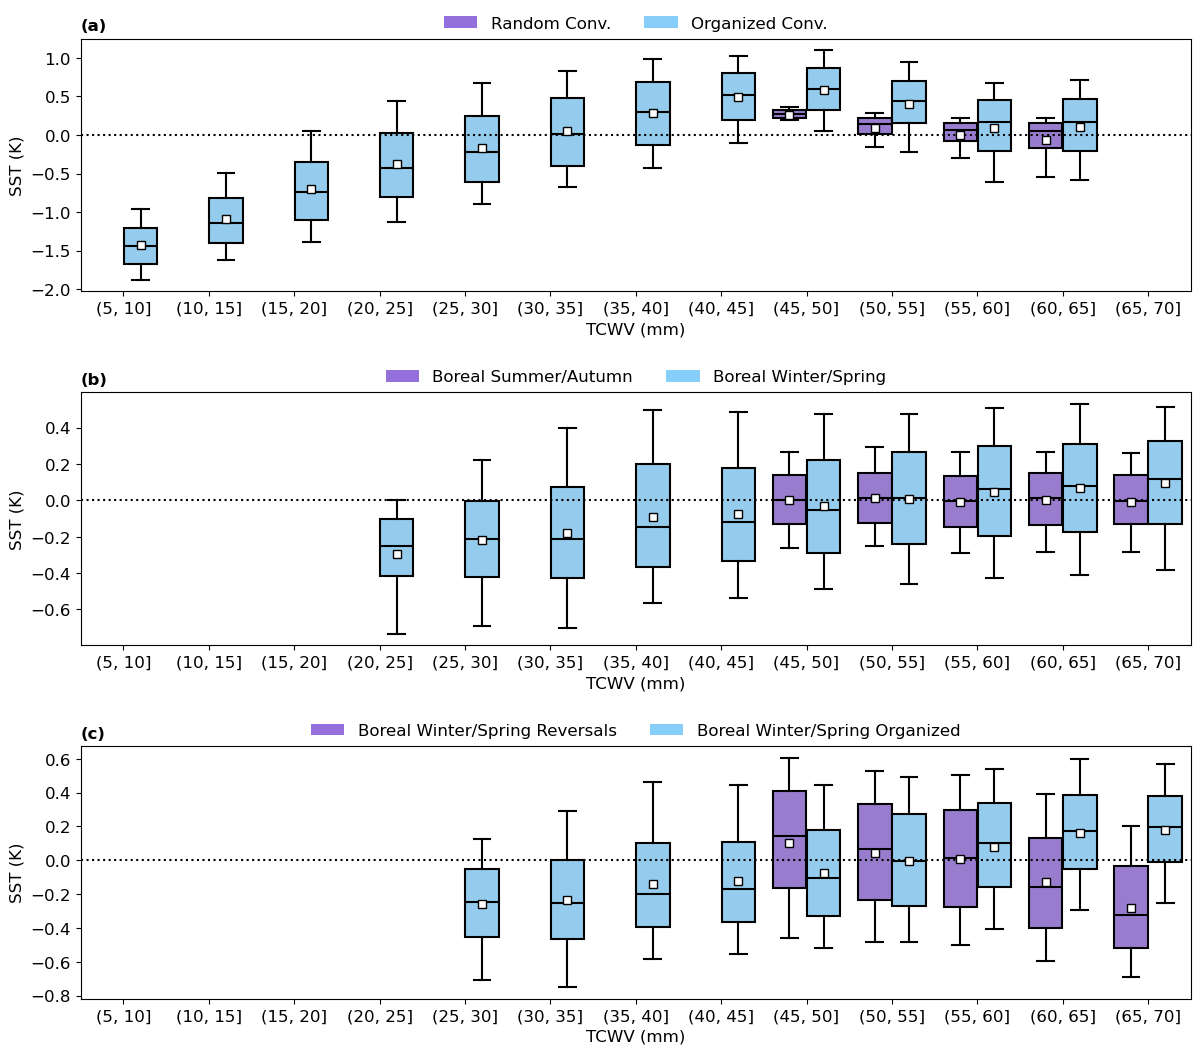

In [28]:
plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(3,1, left=0.05, right=0.975, hspace=0.4, wspace=0.0, top=0.9, bottom=0.1)
ax=subplot(gs[0])
bp = sns.boxplot(data = df_tot, x='bins', y='Value', hue='Conditions', whis=[10,90],
                 palette=['mediumpurple','lightskyblue'],showmeans=True,
                 flierprops = dict(marker='.', markersize=3, color = 'k', markeredgecolor = 'k'),
                 meanprops = {"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"},
                 boxprops = dict(edgecolor='black'),
                 medianprops = dict(color = 'black'),
                 whiskerprops = dict(color = 'black'),
                 capprops = dict(color = 'black'), showfliers= False)
plt.axhline(0, color = 'k', linestyle=':')
#plt.axhline(rev_sst.mean(), color = 'k', linestyle=':')
random = mpatches.Rectangle((0, 0), 1, 1, facecolor="mediumpurple")
organized = mpatches.Rectangle((0, 0), 1, 1, facecolor="lightskyblue")
plt.legend([random,organized], ['Random Conv.','Organized Conv.'], loc = 'upper center', ncol=2,
           bbox_to_anchor = (0.5,1.15), frameon = False, fontsize = 12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('(a)', loc = 'left', fontweight = 'bold')
plt.ylabel('SST (K)', fontsize = 12)
plt.xlabel('TCWV (mm)', fontsize = 12)
#plt.ylim(-1.25,1.25)

ax=subplot(gs[1])
bp = sns.boxplot(data = df_tot_obs, x='bins', y='Value', hue='Conditions', whis=[10,90],
                 palette=['mediumpurple','lightskyblue'],showmeans=True,
                 flierprops = dict(marker='.', markersize=3, color = 'k', markeredgecolor = 'k'),
                 meanprops = {"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"},
                 boxprops = dict(edgecolor='black'),
                 medianprops = dict(color = 'black'),
                 whiskerprops = dict(color = 'black'),
                 capprops = dict(color = 'black'), showfliers= False)
plt.axhline(0, color = 'k', linestyle=':')
random = mpatches.Rectangle((0, 0), 1, 1, facecolor="mediumpurple")
organized = mpatches.Rectangle((0, 0), 1, 1, facecolor="lightskyblue")
plt.legend([random,organized], ['Boreal Summer/Autumn','Boreal Winter/Spring'], loc = 'upper center', ncol=2,
           bbox_to_anchor = (0.5,1.15), frameon = False, fontsize = 12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.ylim(-0.8,0.8)
plt.title('(b)', loc = 'left', fontweight = 'bold')
plt.ylabel('SST (K)', fontsize = 12)
plt.xlabel('TCWV (mm)', fontsize = 12)

ax=subplot(gs[2])
bp = sns.boxplot(data = df_tot_mam, x='bins', y='Value', hue='Conditions', whis=[10,90],
                 palette=['mediumpurple','lightskyblue'],showmeans=True,
                 flierprops = dict(marker='.', markersize=3, color = 'k', markeredgecolor = 'k'),
                 meanprops = {"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"},
                 boxprops = dict(edgecolor='black'),
                 medianprops = dict(color = 'black'),
                 whiskerprops = dict(color = 'black'),
                 capprops = dict(color = 'black'), showfliers= False)
plt.axhline(0, color = 'k', linestyle=':')
random = mpatches.Rectangle((0, 0), 1, 1, facecolor="mediumpurple")
organized = mpatches.Rectangle((0, 0), 1, 1, facecolor="lightskyblue")
plt.legend([random,organized], ['Boreal Winter/Spring Reversals','Boreal Winter/Spring Organized'], 
           loc = 'upper center', ncol=2, bbox_to_anchor = (0.5,1.15), frameon = False, fontsize = 12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.ylim(-0.8,0.8)
plt.title('(c)', loc = 'left', fontweight = 'bold')
plt.ylabel('SST (K)', fontsize = 12)
plt.xlabel('TCWV (mm)', fontsize = 12)
plt.savefig('sst_function_tcwv_ideal_obs_rev_org.jpg', bbox_inches='tight',dpi=300)
plt.savefig('sst_function_tcwv_ideal_obs_rev_org.pdf', bbox_inches='tight',dpi=300)
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning

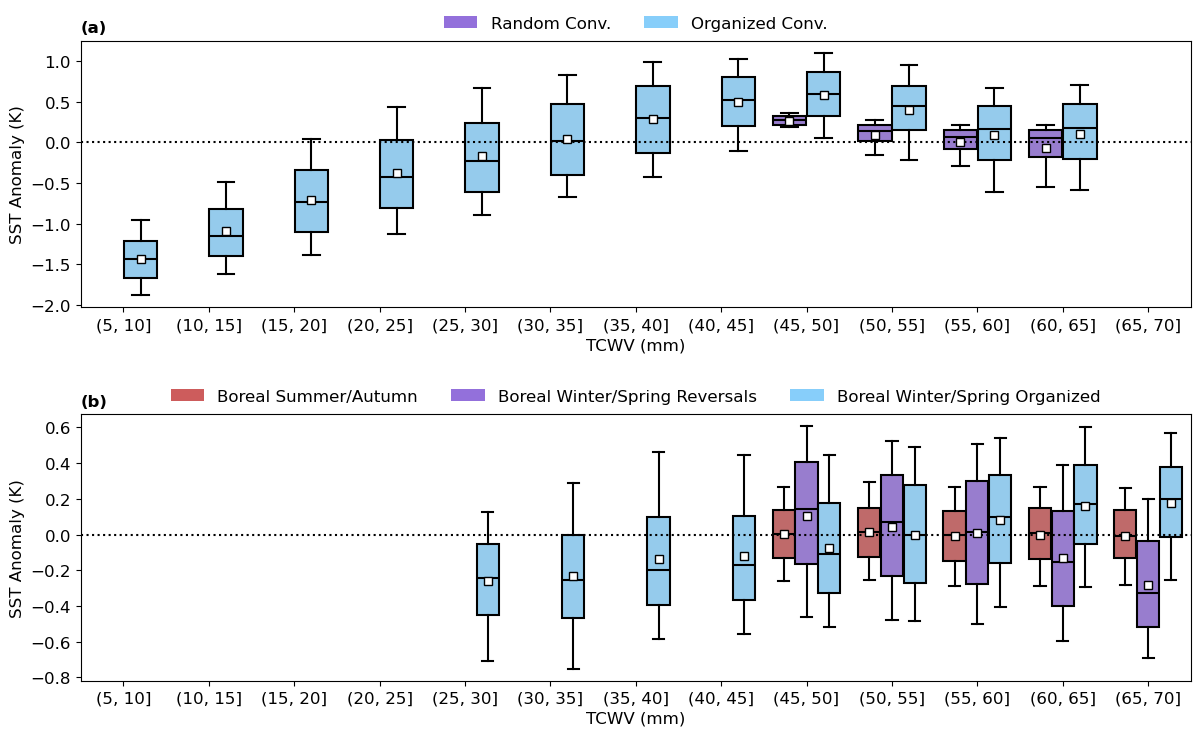

In [29]:
plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(2,1, left=0.05, right=0.975, hspace=0.4, wspace=0.05, top=0.9, bottom=0.1)
ax=subplot(gs[0])
fs = 12
bp = sns.boxplot(data = df_tot, x='bins', y='Value', hue='Conditions', whis=[10,90],
                 palette=['mediumpurple','lightskyblue'],showmeans=True,
                 flierprops = dict(marker='.', markersize=3, color = 'k', markeredgecolor = 'k'),
                 meanprops = {"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"},
                 boxprops = dict(edgecolor='black'),
                 medianprops = dict(color = 'black'),
                 whiskerprops = dict(color = 'black'),
                 capprops = dict(color = 'black'), showfliers= False)
plt.axhline(0, color = 'k', linestyle=':')
#plt.axhline(rev_sst.mean(), color = 'k', linestyle=':')
random = mpatches.Rectangle((0, 0), 1, 1, facecolor="mediumpurple")
organized = mpatches.Rectangle((0, 0), 1, 1, facecolor="lightskyblue")
plt.legend([random,organized], ['Random Conv.','Organized Conv.'], loc = 'upper center', ncol=2,
           bbox_to_anchor = (0.5,1.15), frameon = False, fontsize = fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.title('(a)', loc = 'left', fontweight = 'bold')
plt.ylabel('SST Anomaly (K)', fontsize = fs)
plt.xlabel('TCWV (mm)', fontsize = fs)
#plt.ylim(-1.25,1.25)

ax=subplot(gs[1])
bp = sns.boxplot(data = df_new_plot, x='bins', y='Value', hue='Conditions', whis=[10,90],
                 palette=['indianred','mediumpurple','lightskyblue'],showmeans=True,
                 flierprops = dict(marker='.', markersize=3, color = 'k', markeredgecolor = 'k'),
                 meanprops = {"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"},
                 boxprops = dict(edgecolor='black'),
                 medianprops = dict(color = 'black'),
                 whiskerprops = dict(color = 'black'),
                 capprops = dict(color = 'black'), showfliers= False)
plt.axhline(0, color = 'k', linestyle=':')
jja = mpatches.Rectangle((0, 0), 1, 1, facecolor="indianred")
random = mpatches.Rectangle((0, 0), 1, 1, facecolor="mediumpurple")
organized = mpatches.Rectangle((0, 0), 1, 1, facecolor="lightskyblue")
plt.legend([jja, random,organized], ['Boreal Summer/Autumn','Boreal Winter/Spring Reversals', 
                                    'Boreal Winter/Spring Organized'], 
           loc = 'upper center', ncol=3, bbox_to_anchor = (0.5,1.15), frameon = False, fontsize = fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
#plt.ylim(-0.8,0.8)
plt.title('(b)', loc = 'left', fontweight = 'bold')
plt.ylabel('SST Anomaly (K)', fontsize = fs)
plt.xlabel('TCWV (mm)', fontsize = fs)


plt.savefig('sst_function_tcwv_ideal_obs_rev_org_CRM_OBS.jpg', bbox_inches='tight',dpi=300)
plt.savefig('sst_function_tcwv_ideal_obs_rev_org_CRM_OBS.pdf', bbox_inches='tight',dpi=300)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning

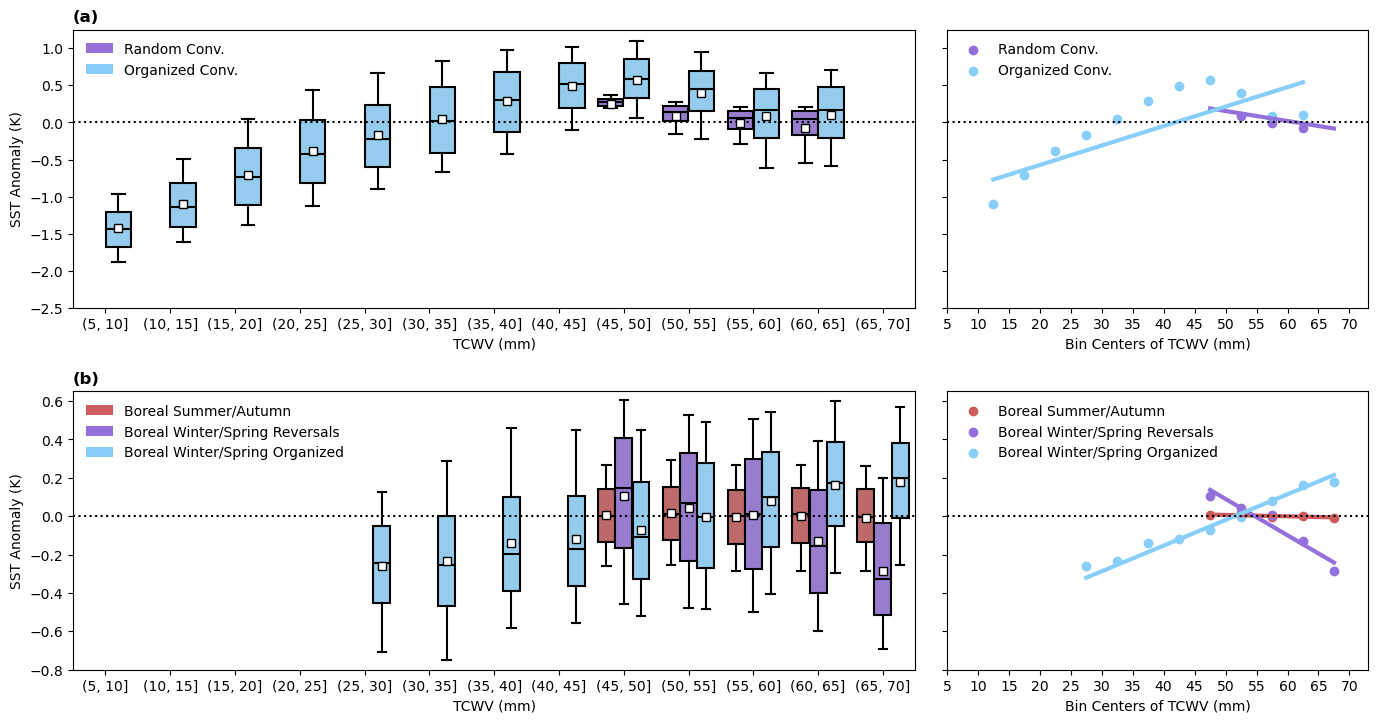

In [30]:
plt.figure(figsize=(14,8))
gs = gridspec.GridSpec(2,2, left=0.05, right=0.975, hspace=0.3, wspace=0.05, top=0.9, bottom=0.1, width_ratios = [1,0.5])
ax=subplot(gs[0])
fs = 10
total_count = len(df_tot)
bin_counts = df_tot['bins'].value_counts()
bin_percentages = (bin_counts / total_count) * 100

# Step 2: Filter out bins with less than 1% data
bins_to_keep = bin_percentages[bin_percentages >= 1].index
df_tot_f = df_tot[df_tot['bins'].isin(bins_to_keep)]

bp = sns.boxplot(data = df_tot_f, x='bins', y='Value', hue='Conditions', whis=[10,90],
                 palette=['mediumpurple','lightskyblue'],showmeans=True,
                 flierprops = dict(marker='.', markersize=3, color = 'k', markeredgecolor = 'k'),
                 meanprops = {"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"},
                 boxprops = dict(edgecolor='black'),
                 medianprops = dict(color = 'black'),
                 whiskerprops = dict(color = 'black'),
                 capprops = dict(color = 'black'), showfliers= False)
plt.axhline(0, color = 'k', linestyle=':')
#plt.axhline(rev_sst.mean(), color = 'k', linestyle=':')
random = mpatches.Rectangle((0, 0), 1, 1, facecolor="mediumpurple")
organized = mpatches.Rectangle((0, 0), 1, 1, facecolor="lightskyblue")
plt.legend([random,organized], ['Random Conv.','Organized Conv.'], loc = 'upper left', ncol=1, frameon = False, fontsize = fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.title('(a)', loc = 'left', fontweight = 'bold')
plt.ylabel('SST Anomaly (K)', fontsize = fs)
plt.xlabel('TCWV (mm)', fontsize = fs)
plt.ylim(-2.5,1.25)
plt.yticks(np.arange(-2.5,1.01,0.5))

ax=subplot(gs[1])
plt.scatter(mod_rev_mean['bin_centers'][1:-1], mod_rev_mean['Value'][1:-1], label='Random Conv.', color = 'mediumpurple')
plt.plot(np.array(mod_rev_mean['bin_centers']), mod_reg_rev[1] + mod_reg_rev[0] * np.array(mod_rev_mean['bin_centers']),
         color = 'mediumpurple', linewidth = 3)

plt.scatter(mod_org_mean['bin_centers'][1:-1], mod_org_mean['Value'][1:-1], label='Organized Conv.', color = 'lightskyblue')
plt.plot(np.array(mod_org_mean['bin_centers'][1:-1]), mod_reg_org[1] + mod_reg_org[0] * np.array(mod_org_mean['bin_centers'][1:-1]),
         color = 'lightskyblue', linewidth = 3)
plt.legend(frameon = False, loc = 'upper left', fontsize = fs)
plt.axhline(0, color = 'k', linestyle = ':')
ax.yaxis.set_major_formatter(NullFormatter())
plt.xlabel('Bin Centers of TCWV (mm)', fontsize = fs)
plt.xlim(5,73)
plt.xticks(np.arange(5,71,5), fontsize = fs)
plt.ylim(-2.5,1.25)
plt.yticks(np.arange(-2.5,1.01,0.5), fontsize = fs)


total_count = len(df_tot)
bin_counts = df_new_plot['bins'].value_counts()
bin_percentages = (bin_counts / total_count) * 100

# Step 2: Filter out bins with less than 1% data
bins_to_keep = bin_percentages[bin_percentages >= 1].index
df_new_plot_f = df_new_plot[df_new_plot['bins'].isin(bins_to_keep)]

ax=subplot(gs[2])
bp = sns.boxplot(data = df_new_plot_f, x='bins', y='Value', hue='Conditions', whis=[10,90],
                 palette=['indianred','mediumpurple','lightskyblue'],showmeans=True,
                 flierprops = dict(marker='.', markersize=3, color = 'k', markeredgecolor = 'k'),
                 meanprops = {"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"},
                 boxprops = dict(edgecolor='black'),
                 medianprops = dict(color = 'black'),
                 whiskerprops = dict(color = 'black'),
                 capprops = dict(color = 'black'), showfliers= False)
plt.axhline(0, color = 'k', linestyle=':')
jja = mpatches.Rectangle((0, 0), 1, 1, facecolor="indianred")
random = mpatches.Rectangle((0, 0), 1, 1, facecolor="mediumpurple")
organized = mpatches.Rectangle((0, 0), 1, 1, facecolor="lightskyblue")
plt.legend([jja, random,organized], ['Boreal Summer/Autumn','Boreal Winter/Spring Reversals', 
                                    'Boreal Winter/Spring Organized'], 
           loc = 'upper left', ncol=1, frameon = False, fontsize = fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
#plt.ylim(-0.8,0.8)
plt.yticks(np.arange(-0.8,0.61,0.2))
plt.ylim(-0.8,0.65)
plt.title('(b)', loc = 'left', fontweight = 'bold')
plt.ylabel('SST Anomaly (K)', fontsize = fs)
plt.xlabel('TCWV (mm)', fontsize = fs)

ax=subplot(gs[3])
plt.scatter(np.array(obs_rev_mean['bin_centers']), obs_rev_mean['Value'], label='Boreal Summer/Autumn', color = 'indianred')
plt.plot(np.array(obs_rev_mean['bin_centers']), obs_rev_reg[1] + obs_rev_reg[0] * np.array(obs_rev_mean['bin_centers']),
         color = 'indianred', linewidth = 3)

plt.scatter(np.array(mam_rev_mean['bin_centers']), mam_rev_mean['Value'], label='Boreal Winter/Spring Reversals', color = 'mediumpurple')
plt.plot(np.array(mam_rev_mean['bin_centers']), mam_reg_rev[1] + mam_reg_rev[0] * np.array(mam_rev_mean['bin_centers']),
         color = 'mediumpurple', linewidth = 3)

plt.scatter(np.array(mam_org_mean['bin_centers'][2:]), mam_org_mean['Value'][2:], color = 'lightskyblue', 
            label = 'Boreal Winter/Spring Organized')
plt.plot(np.array(mam_org_mean['bin_centers'])[2:], mam_reg_org[1] + mam_reg_org[0] * np.array(mam_org_mean['bin_centers'][2:]),
         color = 'lightskyblue', linewidth = 3)

plt.legend(frameon = False, loc = 'upper left', fontsize = fs)
plt.axhline(0, color = 'k', linestyle = ':')
ax.yaxis.set_major_formatter(NullFormatter())
plt.xlabel('Bin Centers of TCWV (mm)', fontsize = fs)
plt.xlim(5,73)
plt.yticks(np.arange(-0.8,0.61,0.2), fontsize = fs)
plt.ylim(-0.8,0.65)
plt.xticks(np.arange(5,71,5), fontsize = fs)

plt.savefig('sst_function_tcwv_ideal_obs_rev_org_CRM_OBS_lin.jpg', bbox_inches='tight',dpi=300)
plt.savefig('sst_function_tcwv_ideal_obs_rev_org_CRM_OBS_lin.pdf', bbox_inches='tight',dpi=300)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning

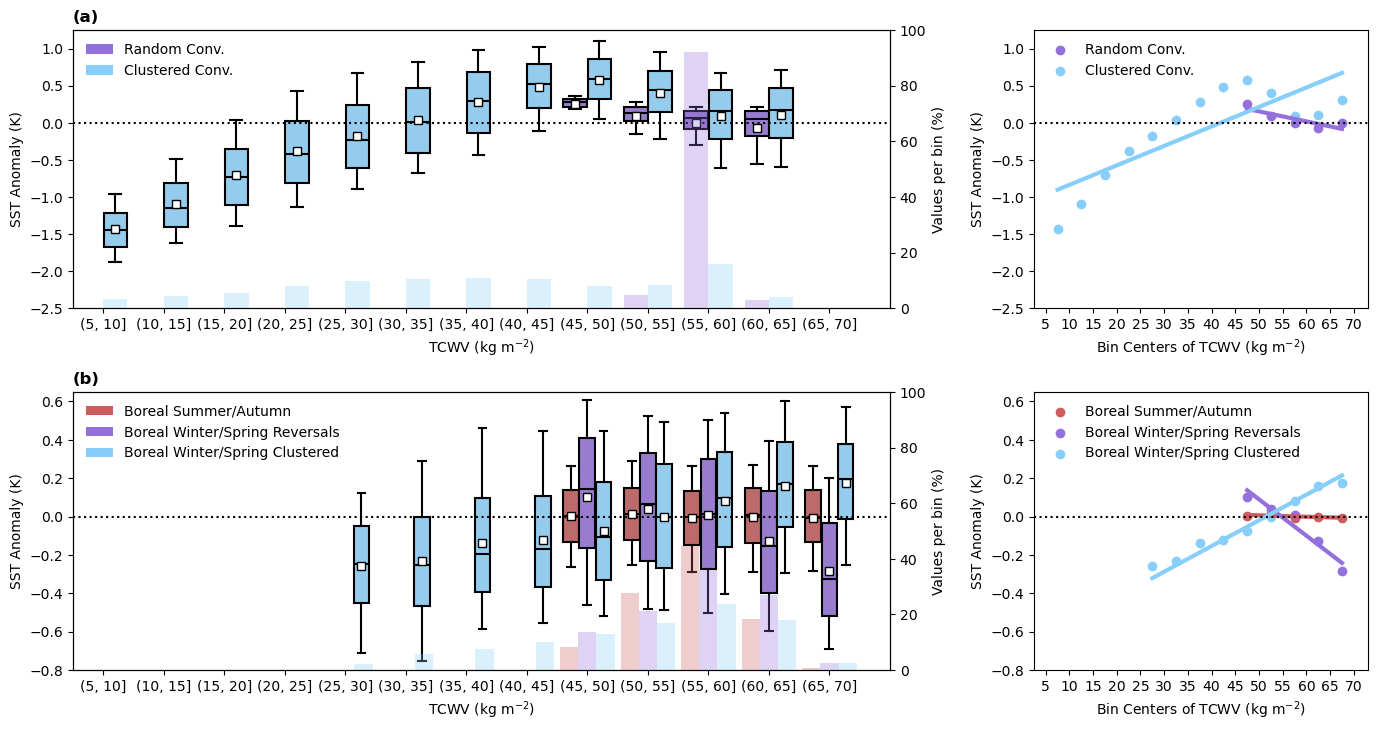

In [33]:
plt.figure(figsize=(14,8))
gs = gridspec.GridSpec(2,2, left=0.05, right=0.975, hspace=0.3, wspace=0.25, top=0.9, bottom=0.1, 
                       width_ratios = [1.1,0.45])
ax=subplot(gs[0])
fs = 10
bin_width = 0.2

bp = sns.boxplot(data = df_tot_f, x='bins', y='Value', hue='Conditions', whis=[10,90],
                 palette=['mediumpurple','lightskyblue'],showmeans=True,
                 flierprops = dict(marker='.', markersize=3, color = 'k', markeredgecolor = 'k'),
                 meanprops = {"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"},
                 boxprops = dict(edgecolor='black'),
                 medianprops = dict(color = 'black'),
                 whiskerprops = dict(color = 'black'),
                 capprops = dict(color = 'black'), showfliers= False)
plt.axhline(0, color = 'k', linestyle=':')
#plt.axhline(rev_sst.mean(), color = 'k', linestyle=':')
random = mpatches.Rectangle((0, 0), 1, 1, facecolor="mediumpurple")
organized = mpatches.Rectangle((0, 0), 1, 1, facecolor="lightskyblue")
plt.legend([random,organized], ['Random Conv.','Clustered Conv.'], loc = 'upper left', ncol=1, frameon = False, fontsize = fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.xlim(-0.5,13)
plt.title('(a)', loc = 'left', fontweight = 'bold')
plt.ylabel('SST Anomaly (K)', fontsize = fs)
plt.xlabel('TCWV (kg m$^{-2}$)', fontsize = fs)
plt.ylim(-2.5,1.25)
plt.yticks(np.arange(-2.5,1.01,0.5))

# Overlay histogram for TCWV in subplot 0
ax_hist = ax.twinx()
conditions = df_tot['Conditions'].unique()
hist_data_total = []
offsets = [-0.2,0.2]

for idx, (condition, color) in enumerate(zip(conditions, ['mediumpurple', 'lightskyblue'])):
    condition_data = df_tot[df_tot['Conditions'] == condition]
    bin_means = condition_data['bins'].apply(lambda x: x.mid if hasattr(x, 'mid') else (x.left + x.right) / 2)
    hist_data, bins = np.histogram(bin_means, bins=np.arange(5, 70 + 1, 5))
    hist_data_total.append(hist_data)
    
    # Normalize to percentages
    hist_data_percent = 100 * hist_data / hist_data.sum()
    #print(hist_data_percent)
    offset = offsets[idx]  # Adjust spacing between conditions
    
    # Plot bars
    ax_hist.bar(np.arange(0,len(hist_data_percent))+offset, hist_data_percent, alpha=0.3, color=color, 
                width=0.4, label=f'{condition} count')

ax_hist.set_ylabel('Values per bin (%)', fontsize=fs)
ax_hist.set_ylim(0, 100)  # Adjust based on your needs
ax_hist.tick_params(axis='y', labelsize=fs)

#####
ax=subplot(gs[1])
plt.scatter(mod_rev_mean['bin_centers'], mod_rev_mean['Value'], label='Random Conv.', color = 'mediumpurple')
plt.plot(np.array(mod_rev_mean['bin_centers']), mod_reg_rev[1] + mod_reg_rev[0] * np.array(mod_rev_mean['bin_centers']),
         color = 'mediumpurple', linewidth = 3)

plt.scatter(mod_org_mean['bin_centers'], mod_org_mean['Value'], label='Clustered Conv.', color = 'lightskyblue')
plt.plot(np.array(mod_org_mean['bin_centers']), mod_reg_org[1] + mod_reg_org[0] * np.array(mod_org_mean['bin_centers']),
         color = 'lightskyblue', linewidth = 3)
plt.legend(frameon = False, loc = 'upper left', fontsize = fs)
plt.axhline(0, color = 'k', linestyle = ':')
plt.ylabel('SST Anomaly (K)', fontsize = fs)
#ax.yaxis.set_major_formatter(NullFormatter())
plt.xlabel('Bin Centers of TCWV (kg m$^{-2}$)', fontsize = fs)
plt.xlim(2.5,73)
plt.xticks(np.arange(5,71,5), fontsize = fs)
plt.ylim(-2.5,1.25)
plt.yticks(np.arange(-2.5,1.01,0.5), fontsize = fs)

ax=subplot(gs[2])
bp = sns.boxplot(data = df_new_plot_f, x='bins', y='Value', hue='Conditions', whis=[10,90],
                 palette=['indianred','mediumpurple','lightskyblue'],showmeans=True,
                 flierprops = dict(marker='.', markersize=3, color = 'k', markeredgecolor = 'k'),
                 meanprops = {"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"},
                 boxprops = dict(edgecolor='black'),
                 medianprops = dict(color = 'black'),
                 whiskerprops = dict(color = 'black'),
                 capprops = dict(color = 'black'), showfliers= False)
plt.axhline(0, color = 'k', linestyle=':')
jja = mpatches.Rectangle((0, 0), 1, 1, facecolor="indianred")
random = mpatches.Rectangle((0, 0), 1, 1, facecolor="mediumpurple")
organized = mpatches.Rectangle((0, 0), 1, 1, facecolor="lightskyblue")
plt.legend([jja, random,organized], ['Boreal Summer/Autumn','Boreal Winter/Spring Reversals', 
                                    'Boreal Winter/Spring Clustered'], 
           loc = 'upper left', ncol=1, frameon = False, fontsize = fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
#plt.ylim(-0.8,0.8)
plt.yticks(np.arange(-0.8,0.61,0.2))
plt.ylim(-0.8,0.65)
plt.xlim(-0.5,13)
plt.title('(b)', loc = 'left', fontweight = 'bold')
plt.ylabel('SST Anomaly (K)', fontsize = fs)
plt.xlabel('TCWV (kg m$^{-2}$)', fontsize = fs)

# Overlay histogram for TCWV 
ax_hist = ax.twinx()
conditions = df_new_plot['Conditions'].unique()
hist_data_total = []
offsets = [-0.3,0,0.3]

for idx, (condition, color) in enumerate(zip(conditions, ['indianred', 'mediumpurple', 'lightskyblue'])):
    condition_data = df_new_plot[df_new_plot['Conditions'] == condition]
    bin_means = condition_data['bins'].apply(lambda x: x.mid if hasattr(x, 'mid') else (x.left + x.right) / 2)
    hist_data, bins = np.histogram(bin_means, bins=np.arange(5, 70 + 1, 5))
    hist_data_total.append(hist_data)
    
    # Normalize to percentages
    hist_data_percent = 100 * hist_data / hist_data.sum()
    offset = offsets[idx]  # Adjust spacing between conditions
    
    # Plot bars
    ax_hist.bar(np.arange(0,len(hist_data_percent))+offset, hist_data_percent, alpha=0.3, color=color, 
                width=0.3, label=f'{condition} count')

ax_hist.set_ylabel('Values per bin (%)', fontsize=fs)
ax_hist.set_ylim(0, 100)  # Adjust based on your needs
ax_hist.tick_params(axis='y', labelsize=fs)


ax=subplot(gs[3])
plt.scatter(np.array(obs_rev_mean['bin_centers']), obs_rev_mean['Value'], label='Boreal Summer/Autumn', color = 'indianred')
plt.plot(np.array(obs_rev_mean['bin_centers']), obs_rev_reg[1] + obs_rev_reg[0] * np.array(obs_rev_mean['bin_centers']),
         color = 'indianred', linewidth = 3)

plt.scatter(np.array(mam_rev_mean['bin_centers']), mam_rev_mean['Value'], label='Boreal Winter/Spring Reversals', color = 'mediumpurple')
plt.plot(np.array(mam_rev_mean['bin_centers']), mam_reg_rev[1] + mam_reg_rev[0] * np.array(mam_rev_mean['bin_centers']),
         color = 'mediumpurple', linewidth = 3)

plt.scatter(np.array(mam_org_mean['bin_centers'][2:]), mam_org_mean['Value'][2:], color = 'lightskyblue', 
            label = 'Boreal Winter/Spring Clustered')
plt.plot(np.array(mam_org_mean['bin_centers'])[2:], mam_reg_org[1] + mam_reg_org[0] * np.array(mam_org_mean['bin_centers'][2:]),
         color = 'lightskyblue', linewidth = 3)

plt.legend(frameon = False, loc = 'upper left', fontsize = fs)
plt.axhline(0, color = 'k', linestyle = ':')
plt.ylabel('SST Anomaly (K)', fontsize = fs)
#ax.yaxis.set_major_formatter(NullFormatter())
plt.xlabel('Bin Centers of TCWV (kg m$^{-2}$)', fontsize = fs)
plt.xlim(2.5,73)
plt.yticks(np.arange(-0.8,0.61,0.2), fontsize = fs)
plt.ylim(-0.8,0.65)
plt.xticks(np.arange(5,71,5), fontsize = fs)
plt.savefig('sst_function_tcwv_ideal_obs_rev_org_CRM_OBS_lin_hist.jpg', bbox_inches='tight',dpi=300)
plt.savefig('sst_function_tcwv_ideal_obs_rev_org_CRM_OBS_lin_hist.pdf', bbox_inches='tight',dpi=300)
plt.show()

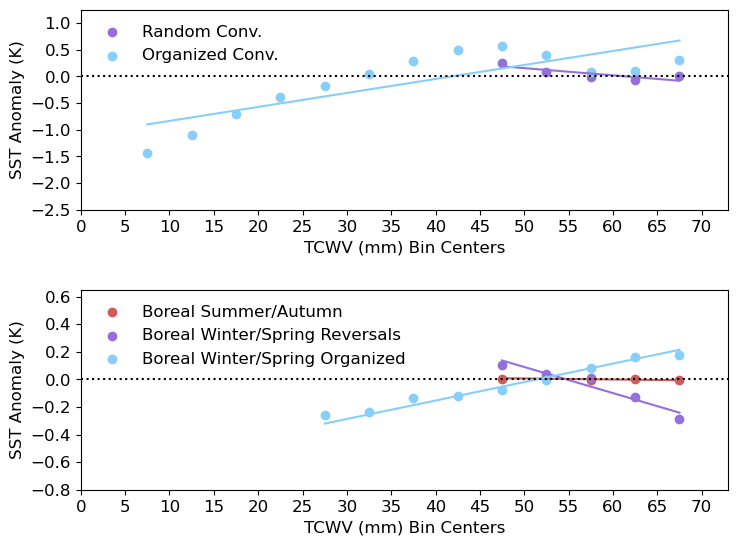

In [32]:
plt.figure(figsize=(7,6))
gs = gridspec.GridSpec(2,1, left=0.05, right=0.975, hspace=0.4, wspace=0.05, top=0.9, bottom=0.1)
fs = 12
ax=subplot(gs[0])
plt.scatter(mod_rev_mean['bin_centers'], mod_rev_mean['Value'], label='Random Conv.', color = 'mediumpurple')
plt.plot(np.array(mod_rev_mean['bin_centers']), mod_reg_rev[1] + mod_reg_rev[0] * np.array(mod_rev_mean['bin_centers']),
         color = 'mediumpurple')

plt.scatter(mod_org_mean['bin_centers'], mod_org_mean['Value'], label='Organized Conv.', color = 'lightskyblue')
plt.plot(np.array(mod_org_mean['bin_centers']), mod_reg_org[1] + mod_reg_org[0] * np.array(mod_org_mean['bin_centers']),
         color = 'lightskyblue')

plt.ylabel('SST Anomaly (K)', fontsize = fs)
plt.legend(frameon = False, loc = 'upper left', fontsize = fs)
plt.axhline(0, color = 'k', linestyle = ':')
plt.xlabel('TCWV (mm) Bin Centers', fontsize = fs)
plt.xlim(0,73)
plt.xticks(np.arange(0,71,5), fontsize = fs)
plt.ylim(-2.5,1.25)
plt.yticks(np.arange(-2.5,1.01,0.5), fontsize = fs)

ax=subplot(gs[1])
plt.scatter(np.array(obs_rev_mean['bin_centers']), obs_rev_mean['Value'], label='Boreal Summer/Autumn', color = 'indianred')
plt.plot(np.array(obs_rev_mean['bin_centers']), obs_rev_reg[1] + obs_rev_reg[0] * np.array(obs_rev_mean['bin_centers']),
         color = 'indianred')

plt.scatter(np.array(mam_rev_mean['bin_centers']), mam_rev_mean['Value'], label='Boreal Winter/Spring Reversals', color = 'mediumpurple')
plt.plot(np.array(mam_rev_mean['bin_centers']), mam_reg_rev[1] + mam_reg_rev[0] * np.array(mam_rev_mean['bin_centers']),
         color = 'mediumpurple')

plt.scatter(np.array(mam_org_mean['bin_centers'][2:]), mam_org_mean['Value'][2:], color = 'lightskyblue', 
            label = 'Boreal Winter/Spring Organized')
plt.plot(np.array(mam_org_mean['bin_centers'])[2:], mam_reg_org[1] + mam_reg_org[0] * np.array(mam_org_mean['bin_centers'][2:]),
         color = 'lightskyblue')

plt.ylabel('SST Anomaly (K)', fontsize = fs)
plt.legend(frameon = False, loc = 'upper left', fontsize = fs)
plt.axhline(0, color = 'k', linestyle = ':')
plt.xlabel('TCWV (mm) Bin Centers', fontsize = fs)
plt.xlim(0,73)
plt.yticks(np.arange(-0.8,0.61,0.2), fontsize = fs)
plt.ylim(-0.8,0.65)
plt.xticks(np.arange(0,71,5), fontsize = fs)

plt.savefig('sst_function_tcwv_ideal_obs_lin_alone.jpg', bbox_inches='tight',dpi=300)
plt.savefig('sst_function_tcwv_ideal_obs_lin_alone.pdf', bbox_inches='tight',dpi=300)
plt.show()